# **Predicting Family Planning Demand and Optimizing Service Delivery in Kenya**

## Project Overview
This project aims to enhance family planning (FP) service delivery efficiency by leveraging data-driven approaches, specifically machine learning (ML) using the CRISP-DM methodology. The goal is to improve maternal and child health outcomes, reduce unmet need for family planning, and contribute to achieving national and global development goals related to reproductive health.

## Problem Statement
Kenya faces significant strides in increasing access to family planning services, yet a substantial unmet need for family planning remains. According to the 2022 Kenya Demographic and Health Survey (KDHS), the total unmet need for family planning is 15%, with 10% for spacing and 5% for limiting births. This indicates that a significant portion of the population desires to space or limit births but is not using any contraceptive method. Traditional methods often show imbalances, with a heavy reliance on short-acting methods, leading to unstable uptake of long-acting reversible contraceptives (LARCs) and permanent methods. This disparity can lead to higher discontinuation rates and continued unmet need. Supply chain inefficiencies, commodity stock-outs, inadequate healthcare worker training, and uneven distribution of resources exacerbate these issues, hindering effective service delivery.

## Stakeholders
* **Government of Kenya:** Ministry of Health (MoH), especially the National Family Planning Coordinated Implementation Plan (NFPICIP) and Kenya Health Information System (KHIS) initiatives.
* **Policymakers and Donors:** Need evidence-based advocacy for resource mobilization and investment.
* **Healthcare Providers:** Frontline health workers providing FP services.
* **Women of Reproductive Age:** Direct beneficiaries of improved FP services.
* **Local Communities:** Impacted by and involved in FP service delivery.

## Key Statistics
* **Total Unmet Need for Family Planning (2022 KDHS):** 15%
    * **Unmet Need for Spacing:** 10%
    * **Unmet Need for Limiting Births:** 5%
* **Married Women Aged 15-49 Rising to 57% in 2022 (DRS 2022):**  Modern contraceptive prevalence rate (mCPR).
* **Number of new clients for FP method band and the continuation rate:** Key data points for predicting future demand.

## Key Analytics Questions
* How many new clients are expected for injectables in a County next quarter?
* What is the projected demand for different family planning methods (injectables, pills, condoms, implants, IUD, sterilization) at various geographical (e.g., county) and temporal (e.g., quarterly, annual) granularities?
* How can we optimize resource allocation (commodities, equipment, staffing) to meet projected demand and minimize wastage?
* How can predictive analytics identify potential stock-outs or oversupply of specific FP commodities in different locations?
* Which regions or demographics are most underserved in terms of family planning access and uptake?

## Objectives
* **Quantitatively forecast the demand for specific family planning methods:** This includes predicting the continuation rates of users for each method at defined geographical and temporal scales.
* **Enable proactive resource allocation:** This involves optimizing the distribution of commodities, equipment, and staffing to reduce stock-outs, minimize wastage, and improve targeted interventions.
* **Improve method continuation:** By understanding demand and improving service delivery, the project aims to reduce discontinuation rates and increase sustained use of FP methods.
* **Provide evidence-based insights:** Support policymakers and donors in making informed decisions regarding resource mobilization and investment in family planning.

## Metrics of Importance to Focus On
* **Accuracy of Demand Forecasts:** Measured by comparing predicted demand with actual uptake for various FP methods at different geographical and temporal levels (e.g., Mean Absolute Error, Root Mean Squared Error).
* **Commodity Stock-out Rates:** Reduction in the number or duration of stock-outs for essential family planning commodities.
* **Resource Utilization Efficiency:** Metrics related to optimal allocation and reduced wastage of commodities, equipment, and human resources.
* **Method Continuation Rates:** Increase in the percentage of users who continue using a specific family planning method over a defined period (e.g., 12-month continuation rate).
* **Unmet Need for Family Planning:** Contribution to the reduction of the national unmet need for family planning.
* **Client Satisfaction:** Indirectly improved through better access and availability of preferred methods.
* **Healthcare Worker Productivity:** Optimized allocation of staff to meet demand efficiently.

# Preliminaries

## Importing Python Libraries

In [1]:
#Import necessary libraries for data manipulation, visualization, and machine learning
# Data handling and manipulation
import pandas as pd                  # For dataframes and data manipulation
import numpy as np                   # For numerical operations and arrays

# Visualization libraries
import matplotlib.pyplot as plt      # For basic plotting
import seaborn as sns                # For advanced statistical visualizations

# Suppress warning messages
import warnings                      # To filter out warnings during execution

# Model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
# train_test_split: splits data into training and test sets
# cross_val_score: performs cross-validation
# TimeSeriesSplit: cross-validation for time series data such as this FP data

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
# StandardScaler/MinMaxScaler: scale numerical features
# OneHotEncoder: encode categorical variables

# Metrics for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# MAE, MSE, R²: performance metrics for regression models

# Combine preprocessing steps
from sklearn.compose import ColumnTransformer  # Apply different preprocessing to columns

# Build machine learning workflows
from sklearn.pipeline import Pipeline          # Chain preprocessing and modeling steps

# Handle missing data
from sklearn.impute import SimpleImputer       # Fill missing values

# Regression models
from sklearn.linear_model import LinearRegression                     # Linear regression model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# RandomForestRegressor: ensemble method using decision trees
# GradientBoostingRegressor: boosting method for better accuracy



## Data Loading

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')  # Mount Google Drive


# base_path = "/content/drive/MyDrive/data/"

# # File paths
# population_data_path = base_path + "ke_fp_population_data.csv"
# service_data_path = base_path + "ke_fp_service_data.csv"
# benchmarks_data_path = base_path + "ke_fp_benchmarks_data.csv"
# commodity_data_path = base_path + "ke_fp_commodity_data.csv"

# # Attempt to read with 'latin1' encoding
# df_population = pd.read_csv(population_data_path, encoding='latin1')
# df_service = pd.read_csv(service_data_path, encoding='latin1')
# df_benchmarks = pd.read_csv(benchmarks_data_path, encoding='latin1')
# df_commodity = pd.read_csv(commodity_data_path, encoding='latin1')


In [3]:
# Data loading

try:
    # Define paths
    data_dir = "data/"
    benchmarks_dir = "data/benchmarks/"

    population_data_path = f"{data_dir}ke_fp_population_data.csv"
    service_data_path = f"{data_dir}ke_fp_service_data.csv"
    commodity_data_path = f"{data_dir}ke_fp_commodity_data.csv"

    benchmarks_core_health_workforce_data_path = f"{benchmarks_dir}ke_fp_benchmarks_core_health_workforce.csv"
    benchmarks_demand_satisfied_data_path = f"{benchmarks_dir}ke_fp_benchmarks_Demand_Satisfied.csv"
    benchmarks_mCPR_data_path = f"{benchmarks_dir}ke_fp_benchmarks_mCPR.csv"
    benchmarks_teen_pregnancy_data_path = f"{benchmarks_dir}ke_fp_benchmarks_Teenage_Pregnancy_rate.csv"
    benchmarks_unmet_need_data_path = f"{benchmarks_dir}ke_fp_benchmarks_Total_Unmet_Need_MW.csv"

    # Load CSVs with fallback encoding
    df_population = pd.read_csv(population_data_path, encoding='latin1')
    df_service = pd.read_csv(service_data_path, encoding='latin1')
    df_commodity = pd.read_csv(commodity_data_path, encoding='latin1')

    # Load benchmark-specific CSVs
    df_core_health_workforce = pd.read_csv(benchmarks_core_health_workforce_data_path, encoding='latin1')
    df_demand_satisfied = pd.read_csv(benchmarks_demand_satisfied_data_path, encoding='latin1')
    df_mcpr = pd.read_csv(benchmarks_mCPR_data_path, encoding='latin1')
    df_teenage_pregnancy = pd.read_csv(benchmarks_teen_pregnancy_data_path, encoding='latin1')
    df_unmet_need = pd.read_csv(benchmarks_unmet_need_data_path, encoding='latin1')

    # Success logs
    print("Datasets loaded successfully:")
    print(f"{population_data_path} shape: {df_population.shape}")
    print(f"{service_data_path} shape: {df_service.shape}")
    print(f"{commodity_data_path} shape: {df_commodity.shape}")
    print(f"{benchmarks_core_health_workforce_data_path} shape: {df_core_health_workforce.shape}")
    print(f"{benchmarks_demand_satisfied_data_path} shape: {df_demand_satisfied.shape}")
    print(f"{benchmarks_mCPR_data_path} shape: {df_mcpr.shape}")
    print(f"{benchmarks_teen_pregnancy_data_path} shape: {df_teenage_pregnancy.shape}")
    print(f"{benchmarks_unmet_need_data_path} shape: {df_unmet_need.shape}")

except FileNotFoundError as e:
    print("❌ Error: One or more CSV files were not found.")
    print("🔍 Please ensure all expected files are in their respective folders.")
    print(e)
except Exception as e:
    print("❗ An unexpected error occurred while loading the datasets:")
    print(e)



Datasets loaded successfully:
data/ke_fp_population_data.csv shape: (517, 19)
data/ke_fp_service_data.csv shape: (6204, 60)
data/ke_fp_commodity_data.csv shape: (2480, 50)
data/benchmarks/ke_fp_benchmarks_core_health_workforce.csv shape: (47, 8)
data/benchmarks/ke_fp_benchmarks_Demand_Satisfied.csv shape: (47, 8)
data/benchmarks/ke_fp_benchmarks_mCPR.csv shape: (47, 8)
data/benchmarks/ke_fp_benchmarks_Teenage_Pregnancy_rate.csv shape: (47, 8)
data/benchmarks/ke_fp_benchmarks_Total_Unmet_Need_MW.csv shape: (47, 8)


# **1. Data Understanding**

## *a) Data Cleaning*

This involved;
* Standardization of the column names
* Renaming the columns
* Dropping empty and unwanted columns
* Handling missing values, duplicates and outliers

### 1. ke_fp_service_data.csv

In [4]:
# Make a copy of the data
df_service1=df_service.copy()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Preview the data
df_service1.head()

,periodid,periodname,periodcode,perioddescription,orgunitlevel1,orgunitlevel2,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,...,MOH 711 Rev 2020_Post parturm FP 4weeks to 6weeks Re-visits,MOH 711 Rev 2020_Post parturm FP within 48 Hours New clients,MOH 711 Rev 2020_Post parturm FP within 48 Hours Re-visits,MOH 711 Rev 2020_Voluntary Surgical Contraception Vasectomy Ist Time Insertion,MOH 711 Rev 2020_Voluntary Surgical Contraception Vasectomy Re-insertion,MOH 711 Rev 2020_Voluntary surgical contraception BTL Ist Time Insertion,MOH 711 Rev 2020_Voluntary surgical contraception BTL Re-insertion,Population Growth Rate,Total Population,Women of childbearing age (15â49yrs)
0,201404,April 2014,201404,NaN,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.16,999367.0,225176.0
1,201404,April 2014,201404,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.02,938866.0,223505.0
2,201404,April 2014,201404,NaN,Kenya,West Pokot County,XWALbfAPa6n,West Pokot County,KE_County_24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10,597313.0,144549.0
3,201404,April 2014,201404,NaN,Kenya,Bomet County,HMNARUV2CW4,Bomet County,KE_County_36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1568.96,834381.7,237820.0
4,201404,April 2014,201404,NaN,Kenya,Nairobi County,jkG3zaihdSs,Nairobi County,KE_County_47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.02,3894186.0,981191.0


In [7]:
# Explore the data
df_service1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 60 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   periodid                                                                        6204 non-null   int64  
 1   periodname                                                                      6204 non-null   object 
 2   periodcode                                                                      6204 non-null   int64  
 3   perioddescription                                                               0 non-null      float64
 4   orgunitlevel1                                                                   6204 non-null   object 
 5   orgunitlevel2                                                                   6204 non-null   object 
 6   organisationunit

In [8]:
# Standardize the column names

def standardize_col_labels(df):
    def clean_column(col):
        # Remove redundant prefixes
        col = col.replace('MOH 711 Rev ', '')
        col = col.replace('MOH 711 ', '')

        # Formatting
        col = col.strip().lower()          # Convert to lowercase
        col = col.replace(' ', '_')     # Replace spaces with underscores
        col = col.replace('-', '_')  # Replace hyphen with underscores
        col = col.replace('â€“', '_')
        col = col.replace('â', '_')
        return col

    df.columns = [clean_column(col) for col in df.columns]
    return df

df_service1 = standardize_col_labels(df_service1)
df_service1.columns

Index(['periodid', 'periodname', 'periodcode', 'perioddescription',
       'orgunitlevel1', 'orgunitlevel2', 'organisationunitid',
       'organisationunitname', 'organisationunitcode',
       'organisationunitdescription', 'estimated_number_of_pregnant_women',
       'fp_attendance_new_clients', 'fp_attendance_re_visits',
       'adolescent_10_14_yrs_receiving_fp_services_new_clients',
       'adolescent_10_14_yrs_receiving_fp_services_re_visits',
       'adolescent_15_19_yrs_receiving_fp_services_new_clients',
       'adolescent_15_19_yrs_receiving_fp_services_re_visits',
       'adolescent_20_24_yrs_receiving_fp_services_new_clients',
       'adolescent_20_24_yrs_receiving_fp_services_re_visits',
       'client_receiving_male_condoms_new_clients',
       'client_receiving_male_condoms_re_visits',
       'clients_counselled_natural_family_planning_new_clients',
       'clients_counselled_natural_family_planning_re_visits',
       'clients_receiving_female_condoms_new_clients',
      

In [9]:
# Rename column names

name_map = {
    'periodcode': 'year_month',
    'orgunitlevel1': 'country',
    'orgunitlevel2': 'county',
    'organisationunitid': 'uid',
    'organisationunitcode':'county_code',
    'county_cou':'county_code',
    'dataname':'population_indicator'
}
df_service1 = df_service1.rename(columns=name_map)
df_service1

,periodid,periodname,year_month,perioddescription,country,county,uid,organisationunitname,county_code,organisationunitdescription,...,2020_post_parturm_fp_4weeks_to_6weeks_re_visits,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,population_growth_rate,total_population,women_of_childbearing_age_(15_49yrs)
0,201404,April 2014,201404,NaN,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.16,999367.00,225176.00
1,201404,April 2014,201404,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.02,938866.00,223505.00
2,201404,April 2014,201404,NaN,Kenya,West Pokot County,XWALbfAPa6n,West Pokot County,KE_County_24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10,597313.00,144549.00
3,201404,April 2014,201404,NaN,Kenya,Bomet County,HMNARUV2CW4,Bomet County,KE_County_36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1568.96,834381.70,237820.00
4,201404,April 2014,201404,NaN,Kenya,Nairobi County,jkG3zaihdSs,Nairobi County,KE_County_47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.02,3894186.00,981191.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,September 2024,202409,NaN,Kenya,Isiolo County,bzOfj0iwfDH,Isiolo County,KE_County_11,NaN,...,53.0,17.0,NaN,NaN,NaN,1.0,NaN,2.32,296179.23,67863.42
6200,202409,September 2024,202409,NaN,Kenya,Trans Nzoia County,mThvosEflAU,Trans Nzoia County,KE_County_26,NaN,...,3.0,75.0,54.0,NaN,NaN,1.0,NaN,2.94,1153812.49,277655.62
6201,202409,September 2024,202409,NaN,Kenya,Nakuru County,ob6SxuRcqU4,Nakuru County,KE_County_32,NaN,...,41.0,191.0,34.0,3.0,NaN,15.0,NaN,2.90,2480137.33,651943.27
6202,202409,September 2024,202409,NaN,Kenya,Tharaka Nithi County,T4urHM47nlm,Tharaka Nithi County,KE_County_13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.67,451552.75,113879.15


In [10]:
# Drop columns where all values are null
df_service1=df_service1.dropna(axis=1, how='all')
df_service1

,periodid,periodname,year_month,country,county,uid,organisationunitname,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,...,2020_post_parturm_fp_4weeks_to_6weeks_re_visits,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,population_growth_rate,total_population,women_of_childbearing_age_(15_49yrs)
0,201404,April 2014,201404,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,24517.00,440.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.16,999367.00,225176.00
1,201404,April 2014,201404,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,43784.00,3572.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.02,938866.00,223505.00
2,201404,April 2014,201404,Kenya,West Pokot County,XWALbfAPa6n,West Pokot County,KE_County_24,21198.00,745.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10,597313.00,144549.00
3,201404,April 2014,201404,Kenya,Bomet County,HMNARUV2CW4,Bomet County,KE_County_36,39762.00,2521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1568.96,834381.70,237820.00
4,201404,April 2014,201404,Kenya,Nairobi County,jkG3zaihdSs,Nairobi County,KE_County_47,158875.00,11356.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.02,3894186.00,981191.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,September 2024,202409,Kenya,Isiolo County,bzOfj0iwfDH,Isiolo County,KE_County_11,7422.28,240.0,...,53.0,17.0,NaN,NaN,NaN,1.0,NaN,2.32,296179.23,67863.42
6200,202409,September 2024,202409,Kenya,Trans Nzoia County,mThvosEflAU,Trans Nzoia County,KE_County_26,35675.47,2805.0,...,3.0,75.0,54.0,NaN,NaN,1.0,NaN,2.94,1153812.49,277655.62
6201,202409,September 2024,202409,Kenya,Nakuru County,ob6SxuRcqU4,Nakuru County,KE_County_32,78676.96,10801.0,...,41.0,191.0,34.0,3.0,NaN,15.0,NaN,2.90,2480137.33,651943.27
6202,202409,September 2024,202409,Kenya,Tharaka Nithi County,T4urHM47nlm,Tharaka Nithi County,KE_County_13,13004.53,1061.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.67,451552.75,113879.15


In [11]:
# Drop unwanted columns
df_service1=df_service1.drop(columns=['periodid','organisationunitname', 'periodname','population_growth_rate',
                                       'total_population','women_of_childbearing_age_(15_49yrs)'
                                       ], axis=1)


In [12]:
# Check for missing values
df_service1.isna().sum().sort_values(ascending=False)

2020_voluntary_surgical_contraception_vasectomy_re_insertion          6199
2020_voluntary_surgical_contraception_btl_re_insertion                6172
2020_clients_given_cycle_beads_re_visits                              6120
2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion    5904
2020_clients_receiving_post_abortion_fp_re_visits                     5779
2020_clients_given_cycle_beads_new_clients                            5016
2020_post_parturm_fp_within_48_hours_re_visits                        5005
2020_post_parturm_fp_4weeks_to_6weeks_re_visits                       4776
2020_iucd_insertion_hormonal_re_insertion                             4643
2020_voluntary_surgical_contraception_btl_ist_time_insertion          4619
2020_clients_receiving_post_abortion_fp_new_clients                   4197
2020_iucd_insertion_hormonal_ist_time_insertion                       4189
2020_iucd_insertion_non_hormonal_re_insertion                         4110
2020_fp_injections_dmpa__

Missing values were interpreted as 'no service was provided or dataset missing for the organization unit' and filled with 0

In [13]:
# Fill the missing values with zeros
df_service1 = df_service1.fillna(0)

In [14]:
# Extract year from 'year_month'
df_service1['year'] = df_service1['year_month'].astype(str).str[:4].astype(int)
df_service1

,year_month,country,county,uid,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,fp_attendance_re_visits,adolescent_10_14_yrs_receiving_fp_services_new_clients,adolescent_10_14_yrs_receiving_fp_services_re_visits,...,2020_implants_insertion_2_rod_re_insertion,2020_post_parturm_fp_4weeks_to_6weeks_new_clients,2020_post_parturm_fp_4weeks_to_6weeks_re_visits,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,year
0,201404,Kenya,Turkana County,kphDeKClFch,KE_County_23,24517.00,440.0,896.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
1,201404,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,43784.00,3572.0,7044.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
2,201404,Kenya,West Pokot County,XWALbfAPa6n,KE_County_24,21198.00,745.0,738.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
3,201404,Kenya,Bomet County,HMNARUV2CW4,KE_County_36,39762.00,2521.0,4411.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
4,201404,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,158875.00,11356.0,26382.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,Kenya,Isiolo County,bzOfj0iwfDH,KE_County_11,7422.28,240.0,683.0,1.0,0.0,...,71.0,36.0,53.0,17.0,0.0,0.0,0.0,1.0,0.0,2024
6200,202409,Kenya,Trans Nzoia County,mThvosEflAU,KE_County_26,35675.47,2805.0,7968.0,1.0,1.0,...,491.0,424.0,3.0,75.0,54.0,0.0,0.0,1.0,0.0,2024
6201,202409,Kenya,Nakuru County,ob6SxuRcqU4,KE_County_32,78676.96,10801.0,25114.0,8.0,5.0,...,1004.0,1214.0,41.0,191.0,34.0,3.0,0.0,15.0,0.0,2024
6202,202409,Kenya,Tharaka Nithi County,T4urHM47nlm,KE_County_13,13004.53,1061.0,4490.0,1.0,1.0,...,142.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024


In [15]:
# Create a new column (uid_code)
df_service1['uid_code'] = df_service1[
    ['year_month','uid' ]].astype(str).agg('_'.join, axis=1)

df_service1.head()

,year_month,country,county,uid,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,fp_attendance_re_visits,adolescent_10_14_yrs_receiving_fp_services_new_clients,adolescent_10_14_yrs_receiving_fp_services_re_visits,...,2020_post_parturm_fp_4weeks_to_6weeks_new_clients,2020_post_parturm_fp_4weeks_to_6weeks_re_visits,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,year,uid_code
0,201404,Kenya,Turkana County,kphDeKClFch,KE_County_23,24517.0,440.0,896.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_kphDeKClFch
1,201404,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,43784.0,3572.0,7044.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_t0J75eHKxz5
2,201404,Kenya,West Pokot County,XWALbfAPa6n,KE_County_24,21198.0,745.0,738.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_XWALbfAPa6n
3,201404,Kenya,Bomet County,HMNARUV2CW4,KE_County_36,39762.0,2521.0,4411.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_HMNARUV2CW4
4,201404,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,158875.0,11356.0,26382.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_jkG3zaihdSs


In [16]:
# Create a new column (uid_year)
df_service1['uid_year'] = df_service1[
    ['year','uid' ]].astype(str).agg('_'.join, axis=1)

df_service1.head()

,year_month,country,county,uid,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,fp_attendance_re_visits,adolescent_10_14_yrs_receiving_fp_services_new_clients,adolescent_10_14_yrs_receiving_fp_services_re_visits,...,2020_post_parturm_fp_4weeks_to_6weeks_re_visits,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,year,uid_code,uid_year
0,201404,Kenya,Turkana County,kphDeKClFch,KE_County_23,24517.0,440.0,896.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_kphDeKClFch,2014_kphDeKClFch
1,201404,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,43784.0,3572.0,7044.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_t0J75eHKxz5,2014_t0J75eHKxz5
2,201404,Kenya,West Pokot County,XWALbfAPa6n,KE_County_24,21198.0,745.0,738.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_XWALbfAPa6n,2014_XWALbfAPa6n
3,201404,Kenya,Bomet County,HMNARUV2CW4,KE_County_36,39762.0,2521.0,4411.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_HMNARUV2CW4,2014_HMNARUV2CW4
4,201404,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,158875.0,11356.0,26382.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,201404_jkG3zaihdSs,2014_jkG3zaihdSs


In [17]:
df_service1.columns

Index(['year_month', 'country', 'county', 'uid', 'county_code',
       'estimated_number_of_pregnant_women', 'fp_attendance_new_clients',
       'fp_attendance_re_visits',
       'adolescent_10_14_yrs_receiving_fp_services_new_clients',
       'adolescent_10_14_yrs_receiving_fp_services_re_visits',
       'adolescent_15_19_yrs_receiving_fp_services_new_clients',
       'adolescent_15_19_yrs_receiving_fp_services_re_visits',
       'adolescent_20_24_yrs_receiving_fp_services_new_clients',
       'adolescent_20_24_yrs_receiving_fp_services_re_visits',
       'client_receiving_male_condoms_new_clients',
       'client_receiving_male_condoms_re_visits',
       'clients_counselled_natural_family_planning_new_clients',
       'clients_counselled_natural_family_planning_re_visits',
       'clients_receiving_female_condoms_new_clients',
       'clients_receiving_female_condoms_re_visits',
       'emergency_contraceptive_pill_new_clients',
       'emergency_contraceptive_pill_re_visits',
      

In [18]:
# Check columns with float dtypes
float_cols = df_service1.select_dtypes(include=['float', 'float64']).columns
float_cols

Index(['estimated_number_of_pregnant_women', 'fp_attendance_new_clients',
       'fp_attendance_re_visits',
       'adolescent_10_14_yrs_receiving_fp_services_new_clients',
       'adolescent_10_14_yrs_receiving_fp_services_re_visits',
       'adolescent_15_19_yrs_receiving_fp_services_new_clients',
       'adolescent_15_19_yrs_receiving_fp_services_re_visits',
       'adolescent_20_24_yrs_receiving_fp_services_new_clients',
       'adolescent_20_24_yrs_receiving_fp_services_re_visits',
       'client_receiving_male_condoms_re_visits',
       'clients_counselled_natural_family_planning_new_clients',
       'clients_counselled_natural_family_planning_re_visits',
       'clients_receiving_female_condoms_new_clients',
       'clients_receiving_female_condoms_re_visits',
       'emergency_contraceptive_pill_new_clients',
       'emergency_contraceptive_pill_re_visits',
       'pills_combined_oral_contraceptive_new_clients',
       'pills_combined_oral_contraceptive_re_visits',
       'pill

In [19]:
# Convert float columns to int64
df_service1[float_cols] = df_service1[float_cols].astype('int64')

In [20]:
df_service1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 55 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   year_month                                                          6204 non-null   int64 
 1   country                                                             6204 non-null   object
 2   county                                                              6204 non-null   object
 3   uid                                                                 6204 non-null   object
 4   county_code                                                         6204 non-null   object
 5   estimated_number_of_pregnant_women                                  6204 non-null   int64 
 6   fp_attendance_new_clients                                           6204 non-null   int64 
 7   fp_attendance_re_visits 

### 2. ke_fp_commodity_data.csv

In [21]:
# Make a copy of the data
df_commodity1 = df_commodity.copy()

In [22]:
# Preview the data
df_commodity1.head()

,periodid,periodname,periodcode,perioddescription,orgunitlevel1,orgunitlevel2,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,14-Apr,201404,NaN,Kenya,Kirinyaga County,Ulj33KBau7V,Kirinyaga County,KE_County_20,NaN,...,0,223,1670,245,30,1,253,1445,368,30
1,201404,14-Apr,201404,NaN,Kenya,Kisii County,sPkRcDvhGWA,Kisii County,KE_County_45,NaN,...,0,6,14,70,20,0,0,0,20,0
2,201404,14-Apr,201404,NaN,Kenya,Kisumu County,tAbBVBbueqD,Kisumu County,KE_County_42,NaN,...,1,151,1719,100,0,0,20,78,220,0
3,201404,14-Apr,201404,NaN,Kenya,Makueni County,BoDytkJQ4Qi,Makueni County,KE_County_17,NaN,...,0,31,89,50,40,0,2,289,20,0
4,201404,14-Apr,201404,NaN,Kenya,Kwale County,N7YETT3A9r1,Kwale County,KE_County_2,NaN,...,1,94,1224,250,53,1,7,444,25,0


In [23]:
# Explore the data
df_commodity1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Data columns (total 50 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   periodid                                           2480 non-null   int64  
 1   periodname                                         2480 non-null   object 
 2   periodcode                                         2480 non-null   int64  
 3   perioddescription                                  0 non-null      float64
 4   orgunitlevel1                                      2480 non-null   object 
 5   orgunitlevel2                                      2480 non-null   object 
 6   organisationunitid                                 2480 non-null   object 
 7   organisationunitname                               2480 non-null   object 
 8   organisationunitcode                               2480 non-null   object 
 9   organisa

In [24]:
# Standardize the column names
df_commodity1 = standardize_col_labels(df_commodity1)

df_commodity1.head()

,periodid,periodname,periodcode,perioddescription,orgunitlevel1,orgunitlevel2,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,14-Apr,201404,NaN,Kenya,Kirinyaga County,Ulj33KBau7V,Kirinyaga County,KE_County_20,NaN,...,0,223,1670,245,30,1,253,1445,368,30
1,201404,14-Apr,201404,NaN,Kenya,Kisii County,sPkRcDvhGWA,Kisii County,KE_County_45,NaN,...,0,6,14,70,20,0,0,0,20,0
2,201404,14-Apr,201404,NaN,Kenya,Kisumu County,tAbBVBbueqD,Kisumu County,KE_County_42,NaN,...,1,151,1719,100,0,0,20,78,220,0
3,201404,14-Apr,201404,NaN,Kenya,Makueni County,BoDytkJQ4Qi,Makueni County,KE_County_17,NaN,...,0,31,89,50,40,0,2,289,20,0
4,201404,14-Apr,201404,NaN,Kenya,Kwale County,N7YETT3A9r1,Kwale County,KE_County_2,NaN,...,1,94,1224,250,53,1,7,444,25,0


In [25]:
# Rename column names
df_commodity1 = df_commodity1.rename(columns=name_map)
df_commodity1

,periodid,periodname,year_month,perioddescription,country,county,uid,organisationunitname,county_code,organisationunitdescription,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,14-Apr,201404,NaN,Kenya,Kirinyaga County,Ulj33KBau7V,Kirinyaga County,KE_County_20,NaN,...,0,223,1670,245,30,1,253,1445,368,30
1,201404,14-Apr,201404,NaN,Kenya,Kisii County,sPkRcDvhGWA,Kisii County,KE_County_45,NaN,...,0,6,14,70,20,0,0,0,20,0
2,201404,14-Apr,201404,NaN,Kenya,Kisumu County,tAbBVBbueqD,Kisumu County,KE_County_42,NaN,...,1,151,1719,100,0,0,20,78,220,0
3,201404,14-Apr,201404,NaN,Kenya,Makueni County,BoDytkJQ4Qi,Makueni County,KE_County_17,NaN,...,0,31,89,50,40,0,2,289,20,0
4,201404,14-Apr,201404,NaN,Kenya,Kwale County,N7YETT3A9r1,Kwale County,KE_County_2,NaN,...,1,94,1224,250,53,1,7,444,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,202209,22-Sep,202209,NaN,Kenya,Kericho County,ihZsJ8alvtb,Kericho County,KE_County_35,NaN,...,0,0,0,300,0,0,0,0,0,0
2476,202209,22-Sep,202209,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,...,0,0,0,500,0,0,0,0,0,0
2477,202209,22-Sep,202209,NaN,Kenya,Machakos County,yhCUgGcCcOo,Machakos County,KE_County_16,NaN,...,0,0,0,0,0,0,0,0,0,0
2478,202309,23-Sep,202309,NaN,Kenya,Nairobi County,jkG3zaihdSs,Nairobi County,KE_County_47,NaN,...,0,0,0,0,0,0,2,21,0,0


In [26]:
# Drop columns where all values are null
df_commodity1=df_commodity1.dropna(axis=1, how='all')
df_commodity1

,periodid,periodname,year_month,country,county,uid,organisationunitname,county_code,pills_combined_oral_contraceptive_stock_losses,pills_combined_oral_contraceptive_stock_dispensed,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,14-Apr,201404,Kenya,Kirinyaga County,Ulj33KBau7V,Kirinyaga County,KE_County_20,0,5728,...,0,223,1670,245,30,1,253,1445,368,30
1,201404,14-Apr,201404,Kenya,Kisii County,sPkRcDvhGWA,Kisii County,KE_County_45,0,8,...,0,6,14,70,20,0,0,0,20,0
2,201404,14-Apr,201404,Kenya,Kisumu County,tAbBVBbueqD,Kisumu County,KE_County_42,17,241,...,1,151,1719,100,0,0,20,78,220,0
3,201404,14-Apr,201404,Kenya,Makueni County,BoDytkJQ4Qi,Makueni County,KE_County_17,135,149,...,0,31,89,50,40,0,2,289,20,0
4,201404,14-Apr,201404,Kenya,Kwale County,N7YETT3A9r1,Kwale County,KE_County_2,13,693,...,1,94,1224,250,53,1,7,444,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,202209,22-Sep,202209,Kenya,Kericho County,ihZsJ8alvtb,Kericho County,KE_County_35,0,0,...,0,0,0,300,0,0,0,0,0,0
2476,202209,22-Sep,202209,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,0,420,...,0,0,0,500,0,0,0,0,0,0
2477,202209,22-Sep,202209,Kenya,Machakos County,yhCUgGcCcOo,Machakos County,KE_County_16,0,3653,...,0,0,0,0,0,0,0,0,0,0
2478,202309,23-Sep,202309,Kenya,Nairobi County,jkG3zaihdSs,Nairobi County,KE_County_47,0,0,...,0,0,0,0,0,0,2,21,0,0


In [27]:
# Drop unwanted columns
df_commodity1.drop(columns='organisationunitname', inplace=True)
df_commodity1

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,periodid,periodname,year_month,country,county,uid,county_code,pills_combined_oral_contraceptive_stock_losses,pills_combined_oral_contraceptive_stock_dispensed,pills_combined_oral_contraceptive_stock_at_hand,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,14-Apr,201404,Kenya,Kirinyaga County,Ulj33KBau7V,KE_County_20,0,5728,46036,...,0,223,1670,245,30,1,253,1445,368,30
1,201404,14-Apr,201404,Kenya,Kisii County,sPkRcDvhGWA,KE_County_45,0,8,58,...,0,6,14,70,20,0,0,0,20,0
2,201404,14-Apr,201404,Kenya,Kisumu County,tAbBVBbueqD,KE_County_42,17,241,3542,...,1,151,1719,100,0,0,20,78,220,0
3,201404,14-Apr,201404,Kenya,Makueni County,BoDytkJQ4Qi,KE_County_17,135,149,2588,...,0,31,89,50,40,0,2,289,20,0
4,201404,14-Apr,201404,Kenya,Kwale County,N7YETT3A9r1,KE_County_2,13,693,9289,...,1,94,1224,250,53,1,7,444,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,202209,22-Sep,202209,Kenya,Kericho County,ihZsJ8alvtb,KE_County_35,0,0,0,...,0,0,0,300,0,0,0,0,0,0
2476,202209,22-Sep,202209,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,0,420,43,...,0,0,0,500,0,0,0,0,0,0
2477,202209,22-Sep,202209,Kenya,Machakos County,yhCUgGcCcOo,KE_County_16,0,3653,46174,...,0,0,0,0,0,0,0,0,0,0
2478,202309,23-Sep,202309,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,0,0,60,...,0,0,0,0,0,0,2,21,0,0


In [28]:
# Check for missing values
df_commodity1.isna().sum().sort_values(ascending=False)

iud_stock_received                                   0
pills_combined_oral_contraceptive_stock_received     0
pills_progestin_only_pills_stock_requested           0
pills_progestin_only_pills_stock_at_hand             0
pills_progestin_only_pills_stock_dispensed           0
pills_progestin_only_pills_stock_losses              0
pills_emergency_pill_stock_received                  0
pills_emergency_pill_stock_requested                 0
pills_emergency_pill_stock_at_hand                   0
pills_emergency_pill_stock_dispensed                 0
pills_emergency_pill_stock_losses                    0
pills_combined_oral_contraceptive_stock_requested    0
condoms_female_condom_stock_losses                   0
pills_combined_oral_contraceptive_stock_at_hand      0
pills_combined_oral_contraceptive_stock_dispensed    0
pills_combined_oral_contraceptive_stock_losses       0
county_code                                          0
uid                                                  0
county    

The missing values were interpreted as 'no event reported'

In [29]:
# Dealing with the missing values

df_commodity1 = df_commodity1.fillna(0)

In [30]:
# Check for duplicates
df_commodity1.duplicated().sum()

0

A new column(uid_code) was created by concatenating the year_month column and organisation unit id

In [31]:
# Create a new column (uid_code)
df_commodity1['uid_code'] = df_commodity1[['year_month','uid' ]].astype(str).agg('_'.join, axis=1)

df_commodity1.head()

,periodid,periodname,year_month,country,county,uid,county_code,pills_combined_oral_contraceptive_stock_losses,pills_combined_oral_contraceptive_stock_dispensed,pills_combined_oral_contraceptive_stock_at_hand,...,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received,uid_code
0,201404,14-Apr,201404,Kenya,Kirinyaga County,Ulj33KBau7V,KE_County_20,0,5728,46036,...,223,1670,245,30,1,253,1445,368,30,201404_Ulj33KBau7V
1,201404,14-Apr,201404,Kenya,Kisii County,sPkRcDvhGWA,KE_County_45,0,8,58,...,6,14,70,20,0,0,0,20,0,201404_sPkRcDvhGWA
2,201404,14-Apr,201404,Kenya,Kisumu County,tAbBVBbueqD,KE_County_42,17,241,3542,...,151,1719,100,0,0,20,78,220,0,201404_tAbBVBbueqD
3,201404,14-Apr,201404,Kenya,Makueni County,BoDytkJQ4Qi,KE_County_17,135,149,2588,...,31,89,50,40,0,2,289,20,0,201404_BoDytkJQ4Qi
4,201404,14-Apr,201404,Kenya,Kwale County,N7YETT3A9r1,KE_County_2,13,693,9289,...,94,1224,250,53,1,7,444,25,0,201404_N7YETT3A9r1


In [32]:
# Convert float columns to int64
float_cols_com = df_commodity1.select_dtypes(include=['float', 'float64']).columns
df_commodity1[float_cols_com] = df_commodity1[float_cols_com].astype('int64')
df_commodity1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Data columns (total 48 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   periodid                                           2480 non-null   int64 
 1   periodname                                         2480 non-null   object
 2   year_month                                         2480 non-null   int64 
 3   country                                            2480 non-null   object
 4   county                                             2480 non-null   object
 5   uid                                                2480 non-null   object
 6   county_code                                        2480 non-null   object
 7   pills_combined_oral_contraceptive_stock_losses     2480 non-null   int64 
 8   pills_combined_oral_contraceptive_stock_dispensed  2480 non-null   int64 
 9   pills_combined_oral

### 3. ke_fp_population_data

In [33]:
# Make a copy of the data
df_population1 =df_population.copy()

In [34]:
# Standardize column names
df_population1 = standardize_col_labels(df_population1)

# Preview the data
df_population1.head()

,periodid,periodname,periodcode,perioddescription,orgunitlevel1,orgunitlevel2,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,estimated_number_of_pregnant_women,population_10_14_year_old_girls,women_of_childbearing_age_(15_49yrs),uid_code,uid_year,unnamed:_15,unnamed:_16,unnamed:_17,unnamed:_18
0,2014,2014,2014,NaN,Kenya,Kajiado County,Hsk1YV8kHkT,Kajiado County,KE_County_34,NaN,30521.0,NaN,174354.0,201401_Hsk1YV8kHkT,2014_Hsk1YV8kHkT,NaN,NaN,NaN,NaN
1,2014,2014,2014,NaN,Kenya,Laikipia County,xuFdFy6t9AH,Laikipia County,KE_County_31,NaN,12362.0,NaN,68426.0,201401_xuFdFy6t9AH,2014_xuFdFy6t9AH,NaN,NaN,NaN,NaN
2,2014,2014,2014,NaN,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,NaN,24517.0,NaN,225176.0,201401_kphDeKClFch,2014_kphDeKClFch,NaN,NaN,NaN,NaN
3,2014,2014,2014,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,43784.0,NaN,223505.0,201401_t0J75eHKxz5,2014_t0J75eHKxz5,NaN,NaN,NaN,NaN
4,2014,2014,2014,NaN,Kenya,Elgeyo Marakwet County,MqnLxQBigG0,Elgeyo Marakwet County,KE_County_28,NaN,18424.0,NaN,103238.0,201401_MqnLxQBigG0,2014_MqnLxQBigG0,NaN,NaN,NaN,NaN


In [35]:
# Rename column names
df_population1 = df_population1.rename(columns=name_map)

df_population1.head()

,periodid,periodname,year_month,perioddescription,country,county,uid,organisationunitname,county_code,organisationunitdescription,estimated_number_of_pregnant_women,population_10_14_year_old_girls,women_of_childbearing_age_(15_49yrs),uid_code,uid_year,unnamed:_15,unnamed:_16,unnamed:_17,unnamed:_18
0,2014,2014,2014,NaN,Kenya,Kajiado County,Hsk1YV8kHkT,Kajiado County,KE_County_34,NaN,30521.0,NaN,174354.0,201401_Hsk1YV8kHkT,2014_Hsk1YV8kHkT,NaN,NaN,NaN,NaN
1,2014,2014,2014,NaN,Kenya,Laikipia County,xuFdFy6t9AH,Laikipia County,KE_County_31,NaN,12362.0,NaN,68426.0,201401_xuFdFy6t9AH,2014_xuFdFy6t9AH,NaN,NaN,NaN,NaN
2,2014,2014,2014,NaN,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,NaN,24517.0,NaN,225176.0,201401_kphDeKClFch,2014_kphDeKClFch,NaN,NaN,NaN,NaN
3,2014,2014,2014,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,43784.0,NaN,223505.0,201401_t0J75eHKxz5,2014_t0J75eHKxz5,NaN,NaN,NaN,NaN
4,2014,2014,2014,NaN,Kenya,Elgeyo Marakwet County,MqnLxQBigG0,Elgeyo Marakwet County,KE_County_28,NaN,18424.0,NaN,103238.0,201401_MqnLxQBigG0,2014_MqnLxQBigG0,NaN,NaN,NaN,NaN


In [36]:
# Drop unwanted columns
df_population1.drop(columns=['organisationunitname'], axis=1) # This was dropped because it is the same as county

,periodid,periodname,year_month,perioddescription,country,county,uid,county_code,organisationunitdescription,estimated_number_of_pregnant_women,population_10_14_year_old_girls,women_of_childbearing_age_(15_49yrs),uid_code,uid_year,unnamed:_15,unnamed:_16,unnamed:_17,unnamed:_18
0,2014,2014,2014,NaN,Kenya,Kajiado County,Hsk1YV8kHkT,KE_County_34,NaN,30521.0,NaN,174354.0,201401_Hsk1YV8kHkT,2014_Hsk1YV8kHkT,NaN,NaN,NaN,NaN
1,2014,2014,2014,NaN,Kenya,Laikipia County,xuFdFy6t9AH,KE_County_31,NaN,12362.0,NaN,68426.0,201401_xuFdFy6t9AH,2014_xuFdFy6t9AH,NaN,NaN,NaN,NaN
2,2014,2014,2014,NaN,Kenya,Turkana County,kphDeKClFch,KE_County_23,NaN,24517.0,NaN,225176.0,201401_kphDeKClFch,2014_kphDeKClFch,NaN,NaN,NaN,NaN
3,2014,2014,2014,NaN,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,NaN,43784.0,NaN,223505.0,201401_t0J75eHKxz5,2014_t0J75eHKxz5,NaN,NaN,NaN,NaN
4,2014,2014,2014,NaN,Kenya,Elgeyo Marakwet County,MqnLxQBigG0,KE_County_28,NaN,18424.0,NaN,103238.0,201401_MqnLxQBigG0,2014_MqnLxQBigG0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,2024,2024,2024,NaN,Kenya,Makueni County,BoDytkJQ4Qi,KE_County_17,NaN,26248.0,59388.0,253333.0,202401_BoDytkJQ4Qi,2024_BoDytkJQ4Qi,NaN,NaN,NaN,NaN
513,2024,2024,2024,NaN,Kenya,Kajiado County,Hsk1YV8kHkT,KE_County_34,NaN,43539.0,77142.0,354857.0,202401_Hsk1YV8kHkT,2024_Hsk1YV8kHkT,NaN,NaN,NaN,NaN
514,2024,2024,2024,NaN,Kenya,Kakamega County,BjC1xL40gHo,KE_County_37,NaN,71817.0,172301.0,523862.0,202401_BjC1xL40gHo,2024_BjC1xL40gHo,NaN,NaN,NaN,NaN
515,2024,2024,2024,NaN,Kenya,Muranga County,ahwTMNAJvrL,KE_County_21,NaN,25812.0,53629.0,280830.0,202401_ahwTMNAJvrL,2024_ahwTMNAJvrL,NaN,NaN,NaN,NaN


#### Calculate Women eligible for FP

In [37]:
# Insert the new column, treating NaN values as 0 during the calculation
df_population1['eligible_fp'] = (
    df_population1['women_of_childbearing_age_(15_49yrs)']
    .add(df_population1['population_10_14_year_old_girls'], fill_value=0)
    .sub(df_population1['estimated_number_of_pregnant_women'], fill_value=0)
)

# Display the updated DataFrame
df_population1.head()

,periodid,periodname,year_month,perioddescription,country,county,uid,organisationunitname,county_code,organisationunitdescription,estimated_number_of_pregnant_women,population_10_14_year_old_girls,women_of_childbearing_age_(15_49yrs),uid_code,uid_year,unnamed:_15,unnamed:_16,unnamed:_17,unnamed:_18,eligible_fp
0,2014,2014,2014,NaN,Kenya,Kajiado County,Hsk1YV8kHkT,Kajiado County,KE_County_34,NaN,30521.0,NaN,174354.0,201401_Hsk1YV8kHkT,2014_Hsk1YV8kHkT,NaN,NaN,NaN,NaN,143833.0
1,2014,2014,2014,NaN,Kenya,Laikipia County,xuFdFy6t9AH,Laikipia County,KE_County_31,NaN,12362.0,NaN,68426.0,201401_xuFdFy6t9AH,2014_xuFdFy6t9AH,NaN,NaN,NaN,NaN,56064.0
2,2014,2014,2014,NaN,Kenya,Turkana County,kphDeKClFch,Turkana County,KE_County_23,NaN,24517.0,NaN,225176.0,201401_kphDeKClFch,2014_kphDeKClFch,NaN,NaN,NaN,NaN,200659.0
3,2014,2014,2014,NaN,Kenya,Nandi County,t0J75eHKxz5,Nandi County,KE_County_29,NaN,43784.0,NaN,223505.0,201401_t0J75eHKxz5,2014_t0J75eHKxz5,NaN,NaN,NaN,NaN,179721.0
4,2014,2014,2014,NaN,Kenya,Elgeyo Marakwet County,MqnLxQBigG0,Elgeyo Marakwet County,KE_County_28,NaN,18424.0,NaN,103238.0,201401_MqnLxQBigG0,2014_MqnLxQBigG0,NaN,NaN,NaN,NaN,84814.0


### 4. ke_fp_benchmarks_data.csv

In [38]:
# Make copies of the benchmarks dataframes
df_core_health_workforce1 = df_core_health_workforce.copy()
df_demand_satisfied1 = df_demand_satisfied.copy()
df_mcpr1 = df_mcpr.copy()
df_teenage_pregnancy1 = df_teenage_pregnancy.copy()
df_unmet_need1 = df_unmet_need.copy()

In [39]:
# Preview the data
df_core_health_workforce1.head()
df_demand_satisfied1.head()
df_mcpr1.head()
df_teenage_pregnancy1.head()
df_unmet_need1.head()

,organisationunitname,uid,county_cou,benchmark_indicator,"Total Unmet Need (Married Women, %)",year,source,uid_code
0,baringo,vvOK1BxTbet,KE_County_30,"Total Unmet Need (Married Women, %)",16.6,2022,KDHS 2022,202201_vvOK1BxTbet
1,bomet,HMNARUV2CW4,KE_County_36,"Total Unmet Need (Married Women, %)",16.7,2022,KDHS 2022,202201_HMNARUV2CW4
2,bungoma,KGHhQ5GLd4k,KE_County_39,"Total Unmet Need (Married Women, %)",14.6,2022,KDHS 2022,202201_KGHhQ5GLd4k
3,busia,Tvf1zgVZ0K4,KE_County_40,"Total Unmet Need (Married Women, %)",18.6,2022,KDHS 2022,202201_Tvf1zgVZ0K4
4,elgeyo_marakwet,MqnLxQBigG0,KE_County_28,"Total Unmet Need (Married Women, %)",13.5,2022,KDHS 2022,202201_MqnLxQBigG0


## *b) Initial Feature Engineering*

### CYP computation and grouping

Couple Years of Protection(CYP)-CYP measures the estimated protection provided by FP based on the volume of contraceptive method distribution to clients to help monitor health system performance and track trends and progress over time.

In [40]:
# Define CYP conversion factors
cyp_factors = {
    'condoms': 0.0083,
    'emergency_pill': 0.05,
    'pills_combined_oral_contraceptives': 0.0067,
    'pills_progestin_only_contraceptives': 0.0833,
    'injections': 0.25,
    'implants_1_rod': 2.5,
    'implants_2_rod': 3.8,
    'iucd_hormonal': 4.8,
    'iucd_non_hormonal': 4.6,
    'surgical': 10.0
}

# Initialize total_cyp column
df_service1['total_cyp'] = 0

# Compute total_cyp based on matching column names
for col in df_service1.columns:
    if 'condom' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['condoms']

    elif 'emergency' in col and 'pill' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['emergency_pill']

    elif 'combined_oral' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['pills_combined_oral_contraceptives']

    elif 'progestin_only' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['pills_progestin_only_contraceptives']

    elif 'injection' in col or 'dmpa' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['injections']

    elif '1_rod' in col and 'implant' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['implants_1_rod']

    elif '2_rod' in col and 'implant' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['implants_2_rod']

    elif 'iucd' in col and 'hormonal' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['iucd_hormonal']

    elif 'iucd' in col and 'non_hormonal' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['iucd_non_hormonal']

    elif 'surgical' in col or 'vasectomy' in col or 'btl' in col:
        df_service1['total_cyp'] += df_service1[col] * cyp_factors['surgical']


In [41]:
df_service1.head()

,year_month,country,county,uid,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,fp_attendance_re_visits,adolescent_10_14_yrs_receiving_fp_services_new_clients,adolescent_10_14_yrs_receiving_fp_services_re_visits,...,2020_post_parturm_fp_within_48_hours_new_clients,2020_post_parturm_fp_within_48_hours_re_visits,2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion,2020_voluntary_surgical_contraception_vasectomy_re_insertion,2020_voluntary_surgical_contraception_btl_ist_time_insertion,2020_voluntary_surgical_contraception_btl_re_insertion,year,uid_code,uid_year,total_cyp
0,201404,Kenya,Turkana County,kphDeKClFch,KE_County_23,24517,440,896,0,0,...,0,0,0,0,0,0,2014,201404_kphDeKClFch,2014_kphDeKClFch,41.5945
1,201404,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,43784,3572,7044,0,0,...,0,0,0,0,0,0,2014,201404_t0J75eHKxz5,2014_t0J75eHKxz5,80.8429
2,201404,Kenya,West Pokot County,XWALbfAPa6n,KE_County_24,21198,745,738,0,0,...,0,0,0,0,0,0,2014,201404_XWALbfAPa6n,2014_XWALbfAPa6n,18.7608
3,201404,Kenya,Bomet County,HMNARUV2CW4,KE_County_36,39762,2521,4411,0,0,...,0,0,0,0,0,0,2014,201404_HMNARUV2CW4,2014_HMNARUV2CW4,18.5713
4,201404,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,158875,11356,26382,0,0,...,0,0,0,0,0,0,2014,201404_jkG3zaihdSs,2014_jkG3zaihdSs,342.4399


### FP Method Grouping (New vs Revisits)

In [42]:
# Group FP Methods
df_service1['adolescent_10_24_receiving_fp_new'] = (
    df_service1['adolescent_10_14_yrs_receiving_fp_services_new_clients'] +
    df_service1['adolescent_15_19_yrs_receiving_fp_services_new_clients'] +
    df_service1['adolescent_20_24_yrs_receiving_fp_services_new_clients']
)

df_service1['adolescent_10_24_receiving_fp_revisits'] = (
    df_service1['adolescent_10_14_yrs_receiving_fp_services_re_visits'] +
    df_service1['adolescent_15_19_yrs_receiving_fp_services_re_visits'] +
    df_service1['adolescent_20_24_yrs_receiving_fp_services_re_visits']
)

df_service1['adults_25+_receiving_fp_services_new'] = df_service1['2020_adults_25+_receiving_fp_services_new_clients']
df_service1['adults_25+_receiving_fp_services_revisits'] = df_service1['2020_adults_25+_receiving_fp_services_re_visits']

df_service1['condoms_new'] = df_service1['clients_receiving_female_condoms_new_clients'] + df_service1['client_receiving_male_condoms_new_clients']
df_service1['condoms_revisits'] = (
    df_service1['clients_receiving_female_condoms_re_visits'] +
    df_service1['client_receiving_male_condoms_re_visits']
)

df_service1['pills_new'] = (
    df_service1['emergency_contraceptive_pill_new_clients'] +
    df_service1['pills_combined_oral_contraceptive_new_clients'] +
    df_service1['pills_progestin_only_new_clients']
)

df_service1['pills_revisits'] = (
    df_service1['emergency_contraceptive_pill_re_visits'] +
    df_service1['pills_combined_oral_contraceptive_re_visits'] +
    df_service1['pills_progestin_only_re_visits']
)

df_service1['injectable_new'] = (
    df_service1['2020_fp_injections_dmpa__im_new_clients'] +
    df_service1['2020_fp_injections_dmpa__sc_new_clients']
)

df_service1['injectable_revisits'] = (
    df_service1['2020_fp_injections_dmpa__im_re_visits'] +
    df_service1['2020_fp_injections_dmpa__sc_re_visits']
)

df_service1['implants_new'] = (
    df_service1['2020_implants_insertion_1_rod_ist_time_insertion'] +
    df_service1['2020_implants_insertion_2_rod_ist_time_insertion']
)

df_service1['implants_revisits'] = (
    df_service1['2020_implants_insertion_1_rod_re_insertion'] +
    df_service1['2020_implants_insertion_2_rod_re_insertion']
)

df_service1['iucd_new'] = (
    df_service1['2020_iucd_insertion_hormonal_ist_time_insertion'] +
    df_service1['2020_iucd_insertion_non_hormonal_ist_time_insertion']
)

df_service1['iucd_revisits'] = (
    df_service1['2020_iucd_insertion_hormonal_re_insertion'] +
    df_service1['2020_iucd_insertion_non_hormonal_re_insertion']
)

df_service1['surgical_new'] = (
    df_service1['2020_voluntary_surgical_contraception_vasectomy_ist_time_insertion'] +
    df_service1['2020_voluntary_surgical_contraception_btl_ist_time_insertion']
)

df_service1['surgical_revisits'] = (
    df_service1['2020_voluntary_surgical_contraception_vasectomy_re_insertion'] +
    df_service1['2020_voluntary_surgical_contraception_btl_re_insertion']
)


In [43]:
df_service1

,year_month,country,county,uid,county_code,estimated_number_of_pregnant_women,fp_attendance_new_clients,fp_attendance_re_visits,adolescent_10_14_yrs_receiving_fp_services_new_clients,adolescent_10_14_yrs_receiving_fp_services_re_visits,...,pills_new,pills_revisits,injectable_new,injectable_revisits,implants_new,implants_revisits,iucd_new,iucd_revisits,surgical_new,surgical_revisits
0,201404,Kenya,Turkana County,kphDeKClFch,KE_County_23,24517,440,896,0,0,...,199,228,0,0,0,0,0,0,0,0
1,201404,Kenya,Nandi County,t0J75eHKxz5,KE_County_29,43784,3572,7044,0,0,...,692,660,0,0,0,0,0,0,0,0
2,201404,Kenya,West Pokot County,XWALbfAPa6n,KE_County_24,21198,745,738,0,0,...,86,90,0,0,0,0,0,0,0,0
3,201404,Kenya,Bomet County,HMNARUV2CW4,KE_County_36,39762,2521,4411,0,0,...,156,181,0,0,0,0,0,0,0,0
4,201404,Kenya,Nairobi County,jkG3zaihdSs,KE_County_47,158875,11356,26382,0,0,...,2262,6267,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,Kenya,Isiolo County,bzOfj0iwfDH,KE_County_11,7422,240,683,1,0,...,34,40,171,583,133,84,9,3,1,0
6200,202409,Kenya,Trans Nzoia County,mThvosEflAU,KE_County_26,35675,2805,7968,1,1,...,658,637,1164,6236,949,611,89,17,1,0
6201,202409,Kenya,Nakuru County,ob6SxuRcqU4,KE_County_32,78676,10801,25114,8,5,...,3128,4971,3513,13416,4675,1371,533,162,18,0
6202,202409,Kenya,Tharaka Nithi County,T4urHM47nlm,KE_County_13,13004,1061,4490,1,1,...,294,648,644,3420,307,224,33,7,0,0


### FP Method overal banding (pills, condoms, injectables,implants,iucd & surgical)

In [44]:
# Combined method categories
df_service1['condoms'] = df_service1['condoms_new'] + df_service1['condoms_revisits']
df_service1['pills'] = df_service1['pills_new'] + df_service1['pills_revisits']
df_service1['injectables'] = df_service1['injectable_new'] + df_service1['injectable_revisits']
df_service1['implants'] = df_service1['implants_new'] + df_service1['implants_revisits']
df_service1['iucd'] = df_service1['iucd_new'] + df_service1['iucd_revisits']
df_service1['surgical'] = df_service1['surgical_new'] + df_service1['surgical_revisits']

# Compute Total FP methods
df_service1['total_fp'] = (
    df_service1['condoms'] +
    df_service1['pills'] +
    df_service1['injectables'] +
    df_service1['implants'] +
    df_service1['iucd'] +
    df_service1['surgical']
)


In [45]:
# List of columns to keep
keep_cols = [
    'year_month', 'country', 'county', 'uid', 'uid_code','uid_year', 'county_code',
    'adolescent_10_24_receiving_fp_new',
    'adolescent_10_24_receiving_fp_revisits',
    'adults_25+_receiving_fp_services_new',
    'adults_25+_receiving_fp_services_revisits',
    'condoms_new', 'condoms_revisits',
    'pills_new', 'pills_revisits',
    'injectable_new', 'injectable_revisits',
    'implants_new', 'implants_revisits',
    'iucd_new', 'iucd_revisits',
    'surgical_new', 'surgical_revisits',
    'condoms', 'pills', 'injectables', 'implants', 'iucd', 'surgical',
    'total_fp', 'total_cyp'
]

# Keep only the specified columns
df_service1 = df_service1[keep_cols]


#### Drop underlying columns

In [46]:
df_service1.columns

Index(['year_month', 'country', 'county', 'uid', 'uid_code', 'uid_year',
       'county_code', 'adolescent_10_24_receiving_fp_new',
       'adolescent_10_24_receiving_fp_revisits',
       'adults_25+_receiving_fp_services_new',
       'adults_25+_receiving_fp_services_revisits', 'condoms_new',
       'condoms_revisits', 'pills_new', 'pills_revisits', 'injectable_new',
       'injectable_revisits', 'implants_new', 'implants_revisits', 'iucd_new',
       'iucd_revisits', 'surgical_new', 'surgical_revisits', 'condoms',
       'pills', 'injectables', 'implants', 'iucd', 'surgical', 'total_fp',
       'total_cyp'],
      dtype='object')

### Joining the datasets

A left join was used to merge the four datasets. The service data was used as the base data. Organisation unit id code (uid_code) was used to join the four datasets

In [47]:
# Merge df_service1 with df_commodity1
fp_service_comm_df = pd.merge(df_service1, df_commodity1, how='left', on='uid_code')

fp_service_comm_df

,year_month_x,country_x,county_x,uid_x,uid_code,uid_year,county_code_x,adolescent_10_24_receiving_fp_new,adolescent_10_24_receiving_fp_revisits,adults_25+_receiving_fp_services_new,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,Kenya,Turkana County,kphDeKClFch,201404_kphDeKClFch,2014_kphDeKClFch,KE_County_23,0,0,0,...,0.0,2.0,63.0,0.0,0.0,0.0,0.0,87.0,0.0,0.0
1,201404,Kenya,Nandi County,t0J75eHKxz5,201404_t0J75eHKxz5,2014_t0J75eHKxz5,KE_County_29,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201404,Kenya,West Pokot County,XWALbfAPa6n,201404_XWALbfAPa6n,2014_XWALbfAPa6n,KE_County_24,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201404,Kenya,Bomet County,HMNARUV2CW4,201404_HMNARUV2CW4,2014_HMNARUV2CW4,KE_County_36,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201404,Kenya,Nairobi County,jkG3zaihdSs,201404_jkG3zaihdSs,2014_jkG3zaihdSs,KE_County_47,0,0,0,...,4.0,1424.0,20475.0,6407.0,20915.0,6.0,660.0,1990.0,6608.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,Kenya,Isiolo County,bzOfj0iwfDH,202409_bzOfj0iwfDH,2024_bzOfj0iwfDH,KE_County_11,159,248,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6200,202409,Kenya,Trans Nzoia County,mThvosEflAU,202409_mThvosEflAU,2024_mThvosEflAU,KE_County_26,1169,2716,1209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6201,202409,Kenya,Nakuru County,ob6SxuRcqU4,202409_ob6SxuRcqU4,2024_ob6SxuRcqU4,KE_County_32,5821,7755,3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6202,202409,Kenya,Tharaka Nithi County,T4urHM47nlm,202409_T4urHM47nlm,2024_T4urHM47nlm,KE_County_13,314,978,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Rename the column
fp_service_comm_df= fp_service_comm_df.rename(columns={"county_code_x": "county_code"})

fp_service_comm_df

,year_month_x,country_x,county_x,uid_x,uid_code,uid_year,county_code,adolescent_10_24_receiving_fp_new,adolescent_10_24_receiving_fp_revisits,adults_25+_receiving_fp_services_new,...,implants_stock_losses,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received
0,201404,Kenya,Turkana County,kphDeKClFch,201404_kphDeKClFch,2014_kphDeKClFch,KE_County_23,0,0,0,...,0.0,2.0,63.0,0.0,0.0,0.0,0.0,87.0,0.0,0.0
1,201404,Kenya,Nandi County,t0J75eHKxz5,201404_t0J75eHKxz5,2014_t0J75eHKxz5,KE_County_29,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201404,Kenya,West Pokot County,XWALbfAPa6n,201404_XWALbfAPa6n,2014_XWALbfAPa6n,KE_County_24,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201404,Kenya,Bomet County,HMNARUV2CW4,201404_HMNARUV2CW4,2014_HMNARUV2CW4,KE_County_36,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201404,Kenya,Nairobi County,jkG3zaihdSs,201404_jkG3zaihdSs,2014_jkG3zaihdSs,KE_County_47,0,0,0,...,4.0,1424.0,20475.0,6407.0,20915.0,6.0,660.0,1990.0,6608.0,236.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,202409,Kenya,Isiolo County,bzOfj0iwfDH,202409_bzOfj0iwfDH,2024_bzOfj0iwfDH,KE_County_11,159,248,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6200,202409,Kenya,Trans Nzoia County,mThvosEflAU,202409_mThvosEflAU,2024_mThvosEflAU,KE_County_26,1169,2716,1209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6201,202409,Kenya,Nakuru County,ob6SxuRcqU4,202409_ob6SxuRcqU4,2024_ob6SxuRcqU4,KE_County_32,5821,7755,3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6202,202409,Kenya,Tharaka Nithi County,T4urHM47nlm,202409_T4urHM47nlm,2024_T4urHM47nlm,KE_County_13,314,978,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Replace non-finite values (NaN, inf, -inf) with 0
fp_service_comm_df = fp_service_comm_df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [50]:
# Convert float columns to int64
df_float_cols = fp_service_comm_df.select_dtypes(include=['float', 'float64']).columns
df_float_cols

Index(['total_cyp', 'periodid', 'year_month_y',
       'pills_combined_oral_contraceptive_stock_losses',
       'pills_combined_oral_contraceptive_stock_dispensed',
       'pills_combined_oral_contraceptive_stock_at_hand',
       'pills_combined_oral_contraceptive_stock_requested',
       'pills_combined_oral_contraceptive_stock_received',
       'pills_emergency_pill_stock_losses',
       'pills_emergency_pill_stock_dispensed',
       'pills_emergency_pill_stock_at_hand',
       'pills_emergency_pill_stock_requested',
       'pills_emergency_pill_stock_received',
       'pills_progestin_only_pills_stock_losses',
       'pills_progestin_only_pills_stock_dispensed',
       'pills_progestin_only_pills_stock_at_hand',
       'pills_progestin_only_pills_stock_requested',
       'pills_progestin_only_pills_stock_received',
       'condoms_female_condom_stock_losses',
       'condoms_female_condom_stock_dispensed',
       'condoms_female_condom_stock_at_hand',
       'condoms_female_condom_s

In [51]:
fp_service_comm_df[df_float_cols] = fp_service_comm_df[df_float_cols].astype('int64')

In [52]:
fp_service_comm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6204 entries, 0 to 6203
Data columns (total 78 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   year_month_x                                       6204 non-null   int64 
 1   country_x                                          6204 non-null   object
 2   county_x                                           6204 non-null   object
 3   uid_x                                              6204 non-null   object
 4   uid_code                                           6204 non-null   object
 5   uid_year                                           6204 non-null   object
 6   county_code                                        6204 non-null   object
 7   adolescent_10_24_receiving_fp_new                  6204 non-null   int64 
 8   adolescent_10_24_receiving_fp_revisits             6204 non-null   int64 
 9   adults_25+_receivin

In [53]:
# Perform a left merge to retain all rows from fp_service_comm_df
fp_service_comm_pop_df = fp_service_comm_df.merge(
    df_population1[['uid_year', 'eligible_fp']], 
    on='uid_year', 
    how='left'
)

# Preview the merged DataFrame
fp_service_comm_pop_df.head()

,year_month_x,country_x,county_x,uid_x,uid_code,uid_year,county_code,adolescent_10_24_receiving_fp_new,adolescent_10_24_receiving_fp_revisits,adults_25+_receiving_fp_services_new,...,implants_stock_dispensed,implants_stock_at_hand,implants_stock_requested,implants_stock_received,iud_stock_losses,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received,eligible_fp
0,201404,Kenya,Turkana County,kphDeKClFch,201404_kphDeKClFch,2014_kphDeKClFch,KE_County_23,0,0,0,...,2,63,0,0,0,0,87,0,0,200659.0
1,201404,Kenya,Nandi County,t0J75eHKxz5,201404_t0J75eHKxz5,2014_t0J75eHKxz5,KE_County_29,0,0,0,...,0,0,0,0,0,0,0,0,0,179721.0
2,201404,Kenya,West Pokot County,XWALbfAPa6n,201404_XWALbfAPa6n,2014_XWALbfAPa6n,KE_County_24,0,0,0,...,0,0,0,0,0,0,0,0,0,123351.0
3,201404,Kenya,Bomet County,HMNARUV2CW4,201404_HMNARUV2CW4,2014_HMNARUV2CW4,KE_County_36,0,0,0,...,0,0,0,0,0,0,0,0,0,198058.0
4,201404,Kenya,Nairobi County,jkG3zaihdSs,201404_jkG3zaihdSs,2014_jkG3zaihdSs,KE_County_47,0,0,0,...,1424,20475,6407,20915,6,660,1990,6608,236,822316.0


In [54]:
# Merge df_core_health_workforce
data_df = fp_service_comm_pop_df.merge(
    df_core_health_workforce[['uid_code', 'core_health_workforce_per_10,000population']],
    on='uid_code', how='left'
)

In [55]:
# Merge df_demand_satisfied
data_df = data_df.merge(
    df_demand_satisfied1[['uid_code', 'Demand_Satisfied_by_Modern_Methods (%)']],
    on='uid_code', how='left'
)

In [56]:
# Merge df_mcpr
data_df = data_df.merge(
    df_mcpr1[['uid_code', 'mCPR (Married Women, %)']],
    on='uid_code', how='left'
)

In [57]:
# Merge df_teenage_pregnancy
data_df = data_df.merge(
    df_teenage_pregnancy1[['uid_code', 'Teenage Pregnancy Rate (15-19, %)']],
    on='uid_code', how='left'
)

In [58]:
# Merge df_unmet_need
data_df = data_df.merge(
    df_unmet_need1[['uid_code', 'Total Unmet Need (Married Women, %)']],
    on='uid_code', how='left'
)

In [59]:
# Rename the columns by removing suffixes
data_df.columns = [
    col.replace('_x_x', '')
       .replace('_y_y', '')
       .replace('_x', '')
       .replace('_y', '')
       for col in data_df.columns
]


In [60]:
# Preview the data to make sure the columns have been renamed
data_df.head()

,year_month,country,county,uid,uid_code,uidear,county_code,adolescent_10_24_receiving_fp_new,adolescent_10_24_receiving_fp_revisits,adults_25+_receiving_fp_services_new,...,iud_stock_dispensed,iud_stock_at_hand,iud_stock_requested,iud_stock_received,eligible_fp,"core_health_workforce_per_10,000population",Demand_Satisfied_by_Modern_Methods (%),"mCPR (Married Women, %)","Teenage Pregnancy Rate (15-19, %)","Total Unmet Need (Married Women, %)"
0,201404,Kenya,Turkana County,kphDeKClFch,201404_kphDeKClFch,2014_kphDeKClFch,KE_County_23,0,0,0,...,0,87,0,0,200659.0,NaN,NaN,NaN,NaN,NaN
1,201404,Kenya,Nandi County,t0J75eHKxz5,201404_t0J75eHKxz5,2014_t0J75eHKxz5,KE_County_29,0,0,0,...,0,0,0,0,179721.0,NaN,NaN,NaN,NaN,NaN
2,201404,Kenya,West Pokot County,XWALbfAPa6n,201404_XWALbfAPa6n,2014_XWALbfAPa6n,KE_County_24,0,0,0,...,0,0,0,0,123351.0,NaN,NaN,NaN,NaN,NaN
3,201404,Kenya,Bomet County,HMNARUV2CW4,201404_HMNARUV2CW4,2014_HMNARUV2CW4,KE_County_36,0,0,0,...,0,0,0,0,198058.0,NaN,NaN,NaN,NaN,NaN
4,201404,Kenya,Nairobi County,jkG3zaihdSs,201404_jkG3zaihdSs,2014_jkG3zaihdSs,KE_County_47,0,0,0,...,660,1990,6608,236,822316.0,NaN,NaN,NaN,NaN,NaN


In [61]:
data_df.shape

(6204, 84)

In [62]:
# Remove duplicate columns
data_df = data_df.loc[:, ~data_df.columns.duplicated()]


In [63]:
# Checking the merged data for duplicates
data_df.duplicated().sum()

0

In [64]:
# Replace " county" label with blanks in county column

data_df['county'] = data_df['county'].str.replace(' County', '', regex=False)
print(data_df[['county']].head())


       county
0     Turkana
1       Nandi
2  West Pokot
3       Bomet
4     Nairobi


### Export .csv file for data_df

In [65]:
data_df_sorted = data_df.sort_values(by='year_month', ascending=False)

# Export to CSV
data_df_sorted.to_csv("output/data_df.csv", index=False, encoding='utf-8')

## *c) Exploratory Data Analysis (EDA)*

### Descriptive Statistics

#### i) FP service data descriptives

In [66]:
# List of columns to describe
eda_cols = [
    'condoms_new', 'condoms_revisits',
    'pills_new', 'pills_revisits',
    'injectable_new', 'injectable_revisits',
    'implants_new', 'implants_revisits',
    'iucd_new', 'iucd_revisits',
    'surgical_new', 'surgical_revisits'
]

# Basic descriptive statistics
eda_summary = df_service1[eda_cols].describe().T
eda_summary['missing'] = df_service1[eda_cols].isnull().sum()
eda_summary['zeros'] = (df_service1[eda_cols] == 0).sum()
eda_summary['unique'] = df_service1[eda_cols].nunique()
eda_summary['dtype'] = df_service1[eda_cols].dtypes

# Show the summary
print(eda_summary)


                      count         mean          std  min     25%    50%  \
condoms_new          6204.0  1012.755480  2179.557079  4.0  191.75  483.0   
condoms_revisits     6204.0   502.967924  1201.564246  0.0   43.00  144.0   
pills_new            6204.0   622.910058   860.123122  0.0  183.00  387.0   
pills_revisits       6204.0   909.946325  1276.593789  0.0  178.00  492.5   
injectable_new       6204.0   426.390071   762.405961  0.0    0.00    0.0   
injectable_revisits  6204.0  1470.093649  2597.655200  0.0    0.00    0.0   
implants_new         6204.0   427.715506   881.975366  0.0    0.00    0.0   
implants_revisits    6204.0   187.019987   380.439558  0.0    0.00    0.0   
iucd_new             6204.0    52.249194   137.231216  0.0    0.00    0.0   
iucd_revisits        6204.0    17.744842    50.077124  0.0    0.00    0.0   
surgical_new         6204.0     3.200838    10.788603  0.0    0.00    0.0   
surgical_revisits    6204.0     0.026596     0.460010  0.0    0.00    0.0   

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   year_month                                 6204 non-null   int64  
 1   country                                    6204 non-null   object 
 2   county                                     6204 non-null   object 
 3   uid                                        6204 non-null   object 
 4   uid_code                                   6204 non-null   object 
 5   county_code                                6204 non-null   object 
 6   adolescent_10_24_receiving_fp_new          6204 non-null   int64  
 7   adolescent_10_24_receiving_fp_revisits     6204 non-null   int64  
 8   adults_25+_receiving_fp_services_new       6204 non-null   int64  
 9   adults_25+_receiving_fp_services_revisits  6204 non-null   int64  
 10  condo

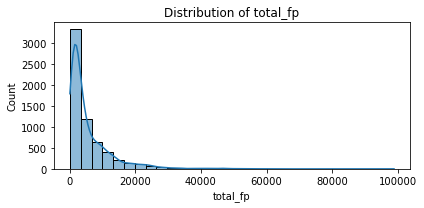

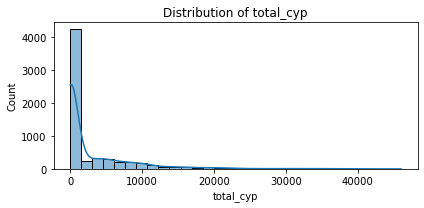

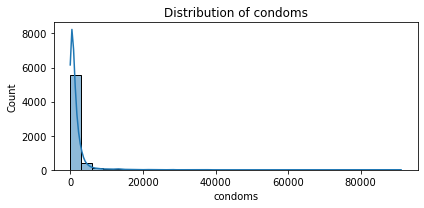

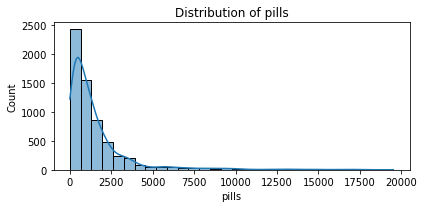

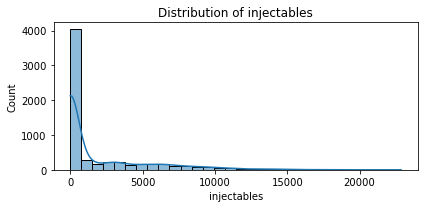

In [67]:
# Columns to describe
eda_columns = [
    'year_month', 'country', 'county', 'uid', 'uid_code', 'county_code',
    'adolescent_10_24_receiving_fp_new', 'adolescent_10_24_receiving_fp_revisits',
    'adults_25+_receiving_fp_services_new', 'adults_25+_receiving_fp_services_revisits',
    'condoms_new', 'condoms_revisits',
    'pills_new', 'pills_revisits',
    'injectable_new', 'injectable_revisits',
    'implants_new', 'implants_revisits',
    'iucd_new', 'iucd_revisits',
    'surgical_new', 'surgical_revisits',
    'condoms', 'pills', 'injectables', 'implants', 'iucd', 'surgical',
    'total_fp', 'total_cyp'
]

# Subset the DataFrame
df_eda = df_service1[eda_columns]

# 1. General info
print("=== Basic Info ===")
print(df_eda.info())

# 2. Missing values
print("=== Missing Values ===")
print(df_eda.isnull().sum())

# 3. Descriptive statistics for numeric columns
print("=== Summary Statistics ===")
print(df_eda.describe().T)

# 4. Unique value counts for categorical columns
cat_cols = ['year_month', 'country', 'county', 'uid', 'uid_code', 'county_code']
print("=== Unique Values in Categorical Columns ===")
for col in cat_cols:
    print(f"{col}: {df_eda[col].nunique()} unique values")

# 5. Trends over time (optional)
if pd.api.types.is_datetime64_any_dtype(df_eda['year_month']):
    trend_data = df_eda.groupby('year_month')['total_fp'].sum()
    trend_data.plot(title="Total FP Over Time", figsize=(10, 4))
    plt.ylabel("Total FP")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 6. Distribution plots for select variables (optional)
num_vars = ['total_fp', 'total_cyp', 'condoms', 'pills', 'injectables']
for var in num_vars:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_eda[var], bins=30, kde=True)
    plt.title(f'Distribution of {var}')
    plt.tight_layout()
    plt.show()


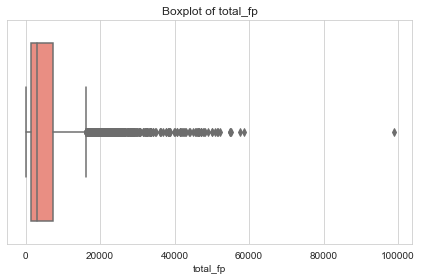

In [ ]:
# Boxplot of total fp
plt.figure(figsize=(6,4))
sns.boxplot(x=data_df['total_fp'].dropna(), color='salmon')
plt.title('Boxplot of total_fp') # Set title
plt.xlabel('total_fp') # Set X_label
plt.tight_layout() # Spacing
plt.show()

In [68]:
# Convert year_month values into datetime objects
data_df['year_month'] = data_df['year_month'].astype(str) # Convert to string

# Split into year and month
data_df['year'] = data_df['year_month'].str[:4].astype(int)
data_df['month'] = data_df['year_month'].str[4:].astype(int)

### What's the FP method mix composition for the period in focus?

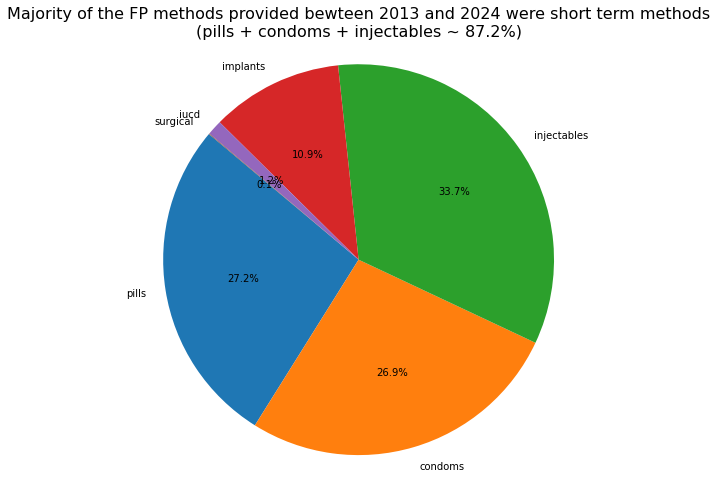

In [69]:
import matplotlib.pyplot as plt
# Group data by year_month and sum the method counts
method_mix = data_df.groupby('year_month')[['pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical']].sum()

# Calculate the total for each method across the entire period
total_method_counts = method_mix.sum()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(total_method_counts, labels=total_method_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Majority of the FP methods provided bewteen 2013 and 2024 were short term methods\n(pills + condoms + injectables ~ 87.2%)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

What's the FP method volume by county?

<Figure size 1440x720 with 0 Axes>

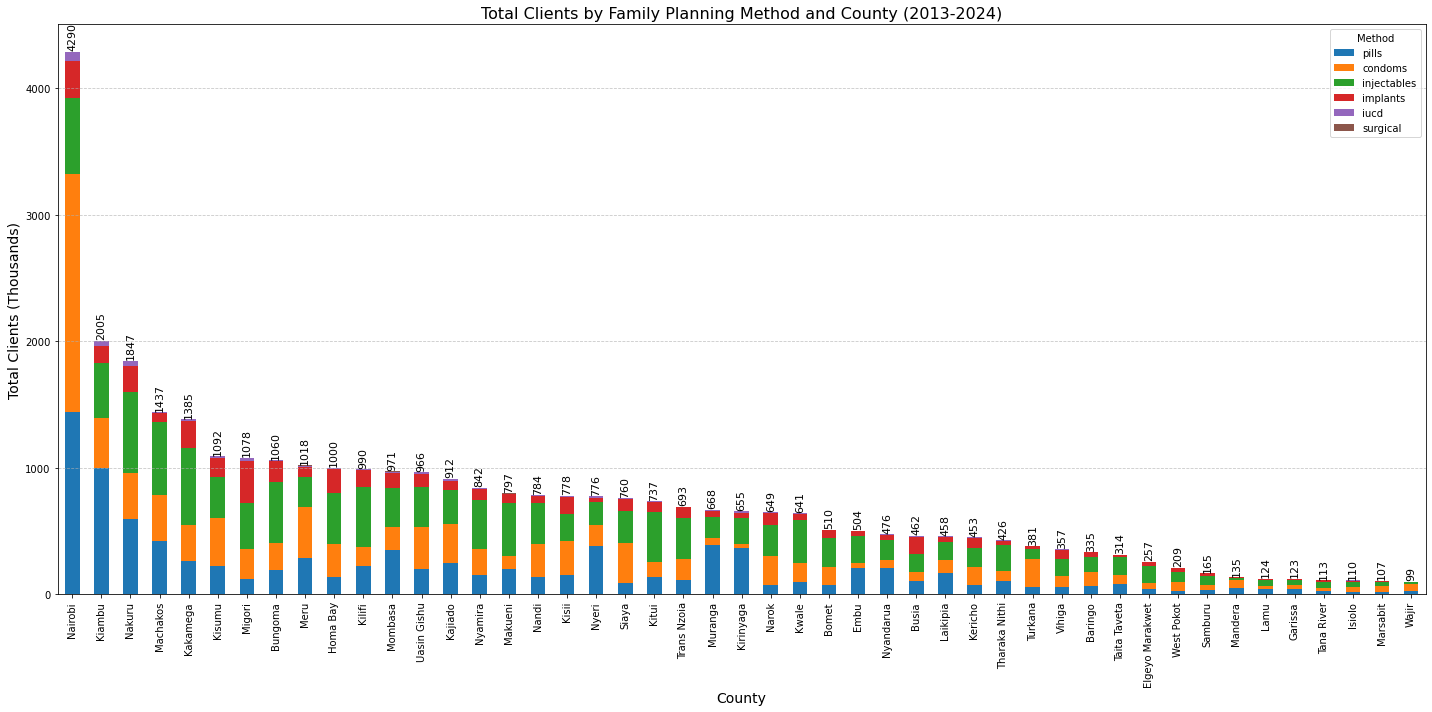

In [70]:
# Method Mix volume by county

# Sum the total counts for each method by county
county_method_totals = data_df.groupby('county')[['pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical']].sum()

# Calculate the total for all methods per county for sorting
county_method_totals['total'] = county_method_totals.sum(axis=1)

# Sort counties by total count in descending order
county_method_totals = county_method_totals.sort_values('total', ascending=False).drop(columns='total')

# Convert values to thousands and format to 0 decimal places
county_method_totals_thousands = county_method_totals / 1000

# Plotting the stacked bar chart
plt.figure(figsize=(20, 10))
ax = county_method_totals_thousands.plot(kind='bar', stacked=True, figsize=(20, 10))

# Add labels and title
plt.xlabel('County', fontsize=14)
plt.ylabel('Total Clients (Thousands)', fontsize=14)
plt.title('Total Clients by Family Planning Method and County (2013-2024)', fontsize=16)
plt.xticks(rotation=90)
plt.legend(title='Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total labels on top of bars
for i, county in enumerate(county_method_totals_thousands.index):
    total_value = county_method_totals_thousands.loc[county].sum()
    # Position the text slightly above the bar. Adjust text position as needed.
    ax.text(i, total_value + 10, f'{total_value:.0f}', ha='center', va='bottom', rotation=90, fontsize=11)


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

### What are the trends in FP Method uptake over time?

<Figure size 1440x720 with 0 Axes>

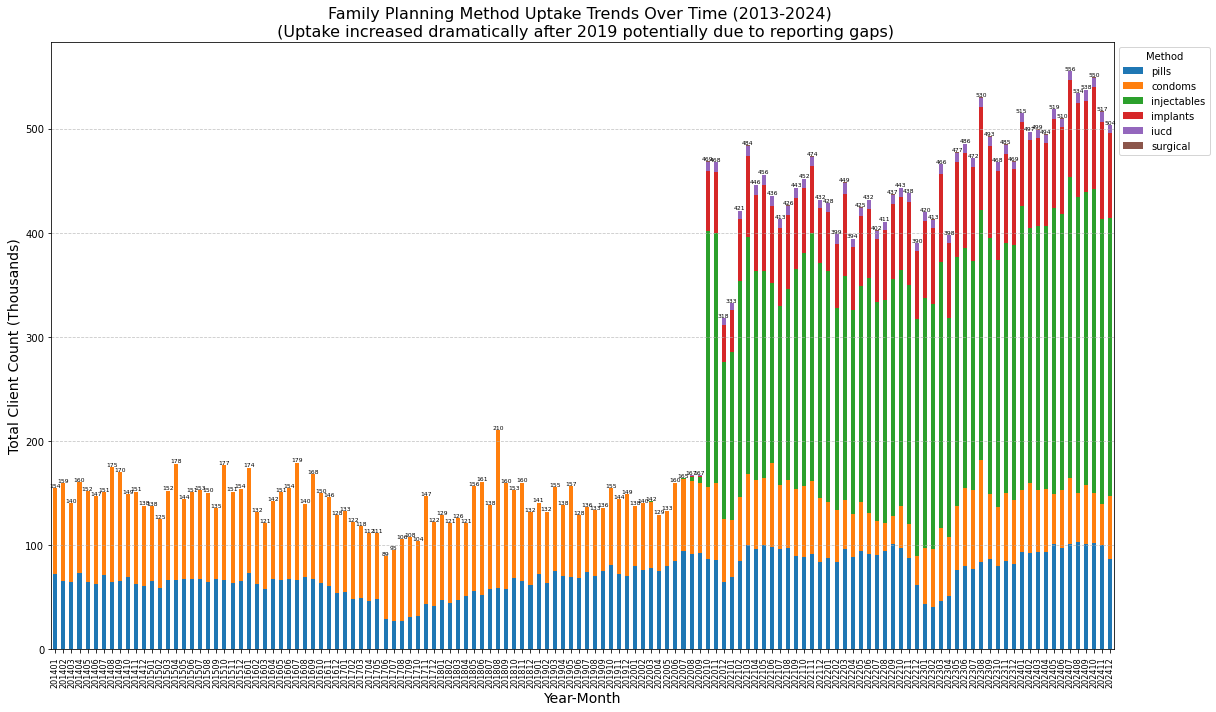

In [71]:
# Plot FP method uptake trends over time

# Group data by year_month and sum the method counts
method_uptake_time = data_df.groupby('year_month')[['pills', 'condoms', 'injectables', 'implants', 'iucd', 'surgical']].sum()

# Convert values to thousands
method_uptake_time_thousands = method_uptake_time / 1000

# Plotting the stacked bar chart
plt.figure(figsize=(20, 10))
ax = method_uptake_time_thousands.plot(kind='bar', stacked=True, figsize=(20, 10))

# Add labels and title
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Client Count (Thousands)', fontsize=14)
plt.title('Family Planning Method Uptake Trends Over Time (2013-2024) \n (Uptake increased dramatically after 2019 potentially due to reporting gaps)', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='Method', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total labels on top of bars
for i, year_month in enumerate(method_uptake_time_thousands.index):
    total_value = method_uptake_time_thousands.loc[year_month].sum()
    # Position the text slightly above the bar. Adjust text position as needed.
    ax.text(i, total_value, f'{total_value:.0f}', ha='center', va='bottom', fontsize=6)


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlapping
plt.show()

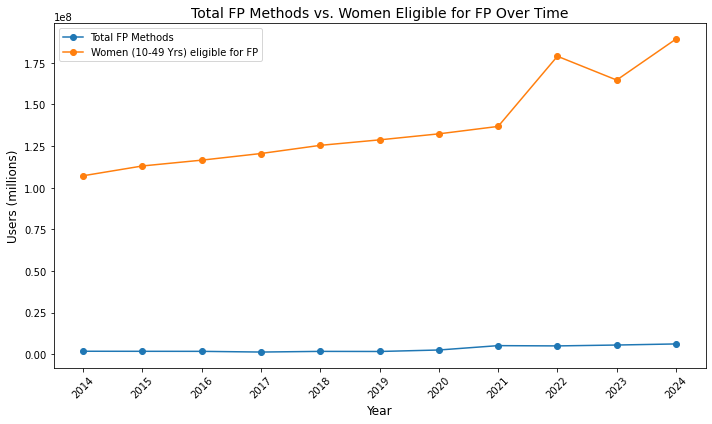

In [72]:
# Plot Total FP Methods vs. Women Eligible for FP Over Time

# Group by year and sum 'total_fp', then get the maximum 'eligible_fp' for each year
trends = data_df.groupby(data_df['year'])[['total_fp', 'eligible_fp']].agg(
    {'total_fp': 'sum', 'eligible_fp': 'sum'}
)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trends.index, trends['total_fp'], label='Total FP Methods', marker='o')
plt.plot(trends.index, trends['eligible_fp'], label='Women (10-49 Yrs) eligible for FP' , marker='o')

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Users (millions)', fontsize=12)
plt.title('Total FP Methods vs. Women Eligible for FP Over Time', fontsize=14)
plt.xticks(trends.index, rotation=45)
plt.legend()
plt.grid(False)

# Show plot
plt.tight_layout()
plt.show()

### Which FP commodities face the greatest supply-demand mismatch?

        commodity  months_with_potential_stockout
0  female_condoms                               0
1        implants                              82
2     injectables                              82
3    male_condoms                               0
4           pills                              92


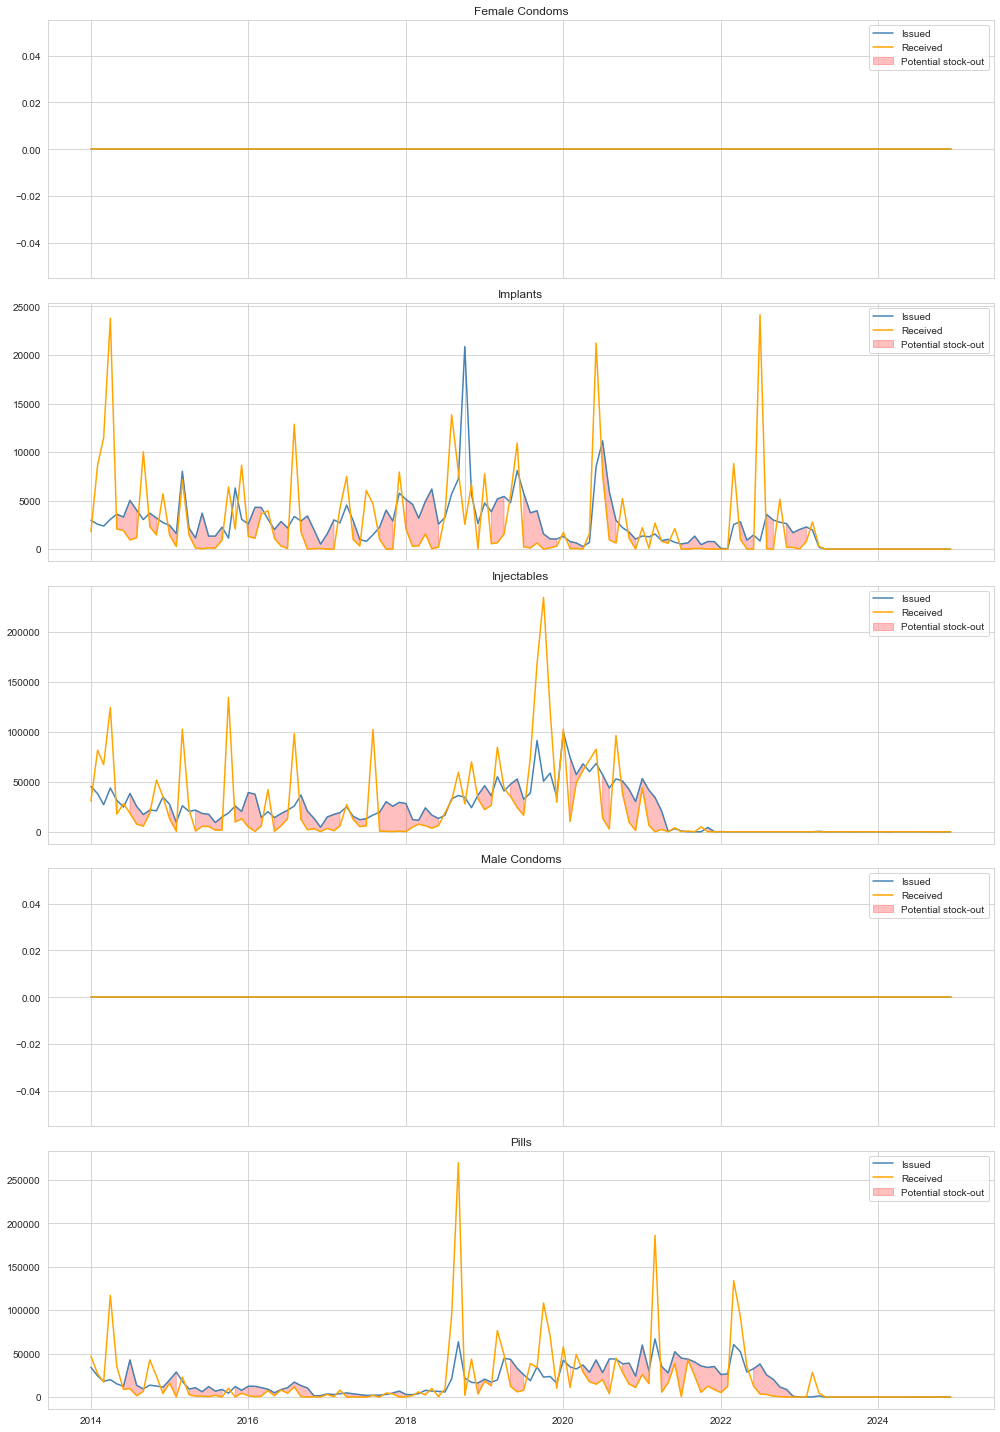

In [109]:
# Create month column (Period) for aggregation
if 'month' not in data_df.columns:
    data_df['month'] = pd.to_datetime(data_df['year_month'], format='%Y%m')

# Commodity issue/received mapping
commodities = {
    'male_condoms': ('condoms_male_condom_stock_dispensed', 'condoms_male_condom_stock_received'),
    'female_condoms': ('condoms_female_condom_stock_dispensed', 'condoms_female_condom_stock_received'),
    'pills': ('pills_combined_oral_contraceptive_stock_dispensed', 'pills_combined_oral_contraceptive_stock_received'),
    'injectables': ('injectables_stock_dispensed', 'injectables_stock_received'),
    'implants': ('implants_stock_dispensed', 'implants_stock_received')
}

# Ensure numeric
for issued, received in commodities.values():
    data_df[issued] = pd.to_numeric(data_df[issued], errors='coerce')
    data_df[received] = pd.to_numeric(data_df[received], errors='coerce')

# Aggregate monthly national
agg_list = []

for name, (issued_col, received_col) in commodities.items():
    monthly = (
        data_df
        .groupby('date')[[issued_col, received_col]]
        .sum()
        .rename(columns={issued_col: 'issued', received_col: 'received'})
    )
    monthly['commodity'] = name
    monthly['coverage_ratio'] = monthly['issued'] / monthly['received'].replace(0, pd.NA)
    monthly['stockout_flag'] = monthly['issued'] > monthly['received']
    agg_list.append(monthly.reset_index())

commod_df = pd.concat(agg_list, ignore_index=True)

#  Count the number of months where issued exceeded receipts (potential stock-out months)
stockouts = commod_df.groupby('commodity')['stockout_flag'].sum().reset_index(name='months_with_potential_stockout')
print(stockouts)

# Visualise issued vs received with stock-out shading
sns.set_style('whitegrid')
fig, axes = plt.subplots(len(commodities), 1, figsize=(14, 4 * len(commodities)), sharex=True)
for ax, (name, grp) in zip(axes, commod_df.groupby('commodity')):
    ax.plot(grp['date'], grp['issued'], label='Issued', color='steelblue')
    ax.plot(grp['date'], grp['received'], label='Received', color='orange')
    ax.fill_between(grp['date'], grp['issued'], grp['received'], where=grp['stockout_flag'], color='red', alpha=0.25, label='Potential stock-out')
    ax.set_title(name.replace('_', ' ').title())
    ax.legend()
plt.tight_layout()
plt.show()


### How well do clients stay on or return for each family planning method once they start, and which methods need the most support to improve continuation?

                 mean       50%       min       max
method                                             
condoms      0.344502  0.402424  0.081719  0.626936
implants     0.283543  0.301429  0.000000  0.500000
injectables  0.749550  0.771955  0.275000  0.840952
iucd         0.245525  0.250819  0.000000  0.447761
pills        0.593910  0.576025  0.477298  0.708238


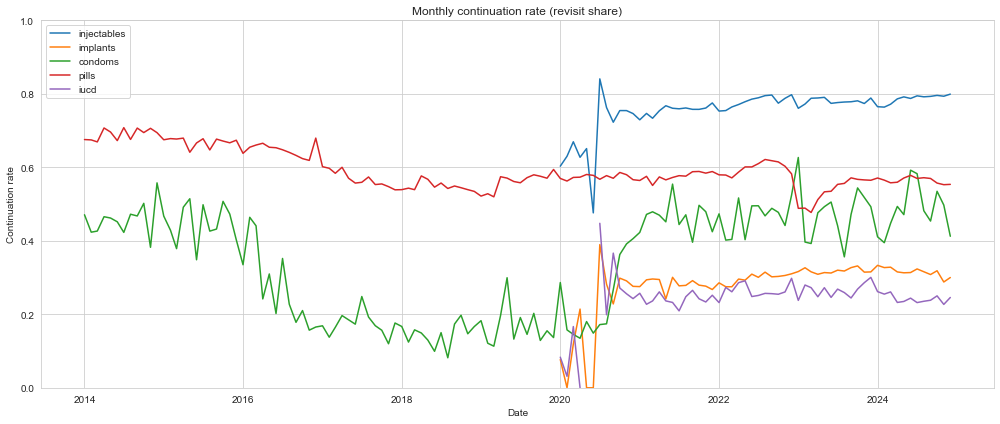

In [110]:
# New vs revisits columns
methods = {
    'condoms': ('condoms_new', 'condoms_revisits'),
    'pills': ('pills_new', 'pills_revisits'),
    'injectables': ('injectable_new', 'injectable_revisits'),
    'implants': ('implants_new', 'implants_revisits'),
    'iucd': ('iucd_new', 'iucd_revisits')
}

data_df['date'] = pd.to_datetime(data_df['year_month'], format='%Y%m')

for pair in methods.values():
    for col in pair:
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

cont_list = []
for name, (new_col, rev_col) in methods.items():
    monthly = data_df.groupby('date')[[new_col, rev_col]].sum().rename(columns={new_col: 'new', rev_col: 'revisit'})
    monthly['method'] = name
    monthly['continuation_rate'] = monthly['revisit'] / (monthly['new'] + monthly['revisit']).replace(0, pd.NA)
    cont_list.append(monthly.reset_index())

cont_df = pd.concat(cont_list)

# Summary continuation stats
cont_summary = cont_df.groupby('method')['continuation_rate'].describe()[['mean','50%','min','max']]
print(cont_summary)

# Plot continuation over time for injectables and implants (common methods)
plt.figure(figsize=(14,6))
for method in ['injectables','implants','condoms','pills', 'iucd']:
    subset = cont_df[cont_df['method'] == method]
    plt.plot(subset['date'], subset['continuation_rate'], label=method)
plt.title('Monthly continuation rate (revisit share)')
plt.ylabel('Continuation rate')
plt.xlabel('Date')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Bivariate Analysis

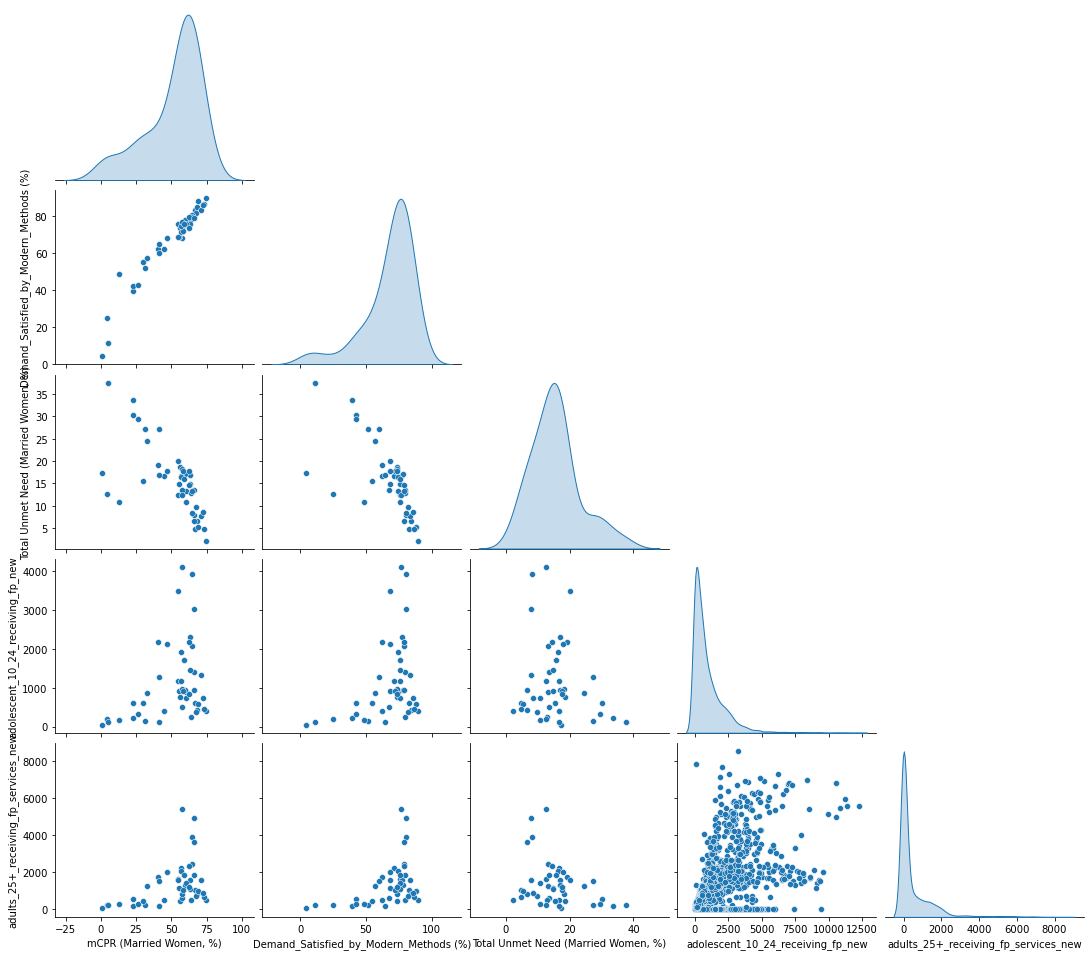

In [73]:
# Select Columns to compare
num_cols = [
    'mCPR (Married Women, %)',
    'Demand_Satisfied_by_Modern_Methods (%)',
    'Total Unmet Need (Married Women, %)',
    'adolescent_10_24_receiving_fp_new',
    'adults_25+_receiving_fp_services_new'
]
df_num = data_df[num_cols]

# Pairplot
sns.pairplot(df_num, corner=True, diag_kind='kde', height=2.8, aspect=1.1)

# Adjust spacing
plt.subplots_adjust(top=0.95)
plt.show()


**Observation**
* Strong positive correlation between mCPR and Demand satisfied by modern methods
* Negative correlation between unmet need and demand satisfied, suggesting improved contraceptive use reduces unmet need.. 

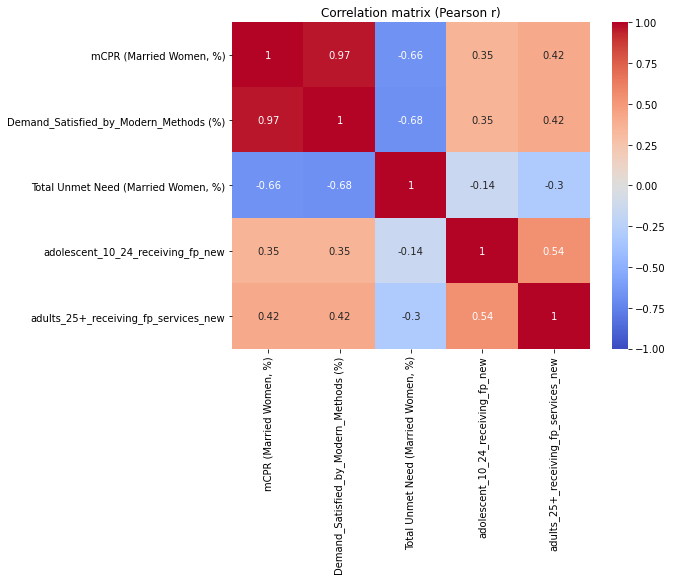

In [74]:
# Correlation matrix
corr = df_num.corr(method='pearson')   # Spearman is an option too

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix (Pearson r)')
plt.show()

Adolescents vs Adults FP uptake

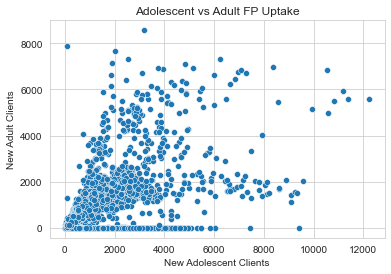

In [113]:
# Scatterplot
sns.scatterplot(data=data_df, x='adolescent_10_24_receiving_fp_new', y='adults_25+_receiving_fp_services_new')
plt.title('Adolescent vs Adult FP Uptake') # Set Title

# Set x,y labels
plt.xlabel('New Adolescent Clients')
plt.ylabel('New Adult Clients')
plt.show()


## *d) Modelling*